<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: NLP subreddit post classifier (ML)

Total runtime: around 2.5 hours

## Problem Statement:
---

For this project, I wish to train a Natural Language Processing classifier to help differentiate reddit posts between [`Marvel`](https://www.reddit.com/r/Marvel/) and [`DCcomics`] (https://www.reddit.com/r/DCcomics/) subreddits. This is a binary classification problem. <br><br>
This project is an introduction to NLP in machine learning.<br><br> 
In [`Project_3_data.ipynb`](./Project_3_data.ipynb), I have webscraped my desired data from 2 subreddits, [`Marvel`](https://www.reddit.com/r/Marvel/) and [`DCcomics`](https://www.reddit.com/r/DCcomics/) respectively. <br><br>
Please refer to [`Project_3_data.ipynb`](./Project_3_data.ipynb) for more details on how the data was extracted.<br><br>
Classifiers will be evaluated based on a range of metrics e.g. accuracy score, roc auc score.

### Contents:

1. [Imported libraries](#Imports:)
1. [Data exploration](#Exploratory-Data-Analysis)<br>
   [New feature **`full_post`**](#New-feature-full_post)<br>
   [Count words](#Count-words)<br>
   [Word clouds](#Word-clouds)
1. [Pre-processing](#Pre-Processing) <br>
   [One-hot encoding `subreddit`](#One-hot-encoding-of-target-subreddit)
1. [Train-test-split `post`](#Train-test-split-post)<br>
   [Tokenizing / Lemmatizing `post`](#Tokenizing-&-Lemmatizing-post)<br>
   [GridSearchCV Random Forest for `post`](#GridSearch-Random-Forest-Classifiers-for-post)<br>
   [Evaluation](#Evaluation-of-GridSearch-Random-Forest-Classifier-models-for-post:)
1. [Train-test-split `full_post`](#Train-test-split-full_post)
1. [Tokenizing / Lemmatizing `full_post`](#Tokenizing-&-Lemmatizing-full_post)
1. [GridSearch Random Forest for `full_post`](#GridSearch-Random-Forest-Classifiers-for-full_post)<br>
   [Evaluation](#Evaluation-of-GridSearch-Random-Forest-Classifier-models-for-full_post:)<br>
   [Tune prediction threshold](#Tune-prediction-threshold-for-GridSearch-Random-Forest-Classifier:)
1. [GridSearch Multinomial NB](#GridSearch-Naive-Bayes-Classifiers)<br>
   [Evaluation](#Evaluation-of-GridSearch-Naive-Bayes-Classifier-models:)<br>
   [Tune prediction threshold](#Tune-prediction-threshold-for-GridSearch-Naive-Bayes-Classifier:)
1. [Standalone Count Vectorization](#Standalone-Count-Vectorization:)
1. [Visualisations](#Visualisations-for-models-comparison:)
1. [Multicollinearity check](#Multicollinearity-check)
1. [Explore wrongly classified posts](#Explore-wrongly-classified-full_post)
1. [Conclusion](#Limitations,-Recommendations-and-Conclusion)

### Algorithms:
---
1. [Random Forest classifier](#GridSearch-Random-Forest-Classifiers)
1. [Multinomial Naive Bayes](#GridSearch-Naive-Bayes-Classifiers)

##### Imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import data
df = pd.read_csv('./data/combined.csv')

In [3]:
# check import correct
df.head(3)

,epoch_time,author,title,post,subreddit
0,1657980098,DarkUpquark,"Watched ""Helstrom"" on hulu",Missed that it actually made it to air in 2020...,Marvel
1,1657974418,CEO_of_Redd1t,Explaining why the MCU is Earth-616 now in the...,So there's been a lot of discussion lately abo...,Marvel
2,1657963597,Short-Step-6704,what should i watch first?,Guys i've never seen any movie from marvel.. s...,Marvel


### Exploratory Data Analysis
---

__Contents:__
* [New feature **`full_post`**](#New-feature-full_post)
* [Count words](#Count-words)
* [Word clouds](#Word-clouds)

__References:__
1. [Bernard Kurka](https://levelup.gitconnected.com/classifying-reddit-posts-with-natural-language-processing-and-random-forest-classifier-af2d8fa77bd3)
1. [Word Cloud Documentation](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud)

In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import re

In [5]:
# 2018 rows
# 1010 'DCcomics', 1008 'Marvel'
df.shape

(2018, 5)

In [6]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   epoch_time  2018 non-null   int64 
 1   author      2018 non-null   object
 2   title       2018 non-null   object
 3   post        2018 non-null   object
 4   subreddit   2018 non-null   object
dtypes: int64(1), object(4)
memory usage: 79.0+ KB


In [7]:
# only 'epoch_time' is numerical
df.describe().T

,count,mean,std,min,25%,50%,75%,max
epoch_time,2018.0,1.656458e+09,974368.75582,1.654189e+09,1.655678e+09,1.656516e+09,1.657328e+09,1.657986e+09


### New feature `full_post`
---

Combine `title` and  `post` features

In [8]:
# make new column (title + post), to get the most of the data
df['full_post'] = df['title'] + ' ' + df['post']

In [9]:
# do separate imports to compare Marvel and DCcomics text
marvel_df = df.loc[df['subreddit']=='Marvel', :]
dcomics_df = df.loc[df['subreddit']=='DCcomics', :]

In [10]:
# preview dataframe to check split
marvel_df.head(3)

,epoch_time,author,title,post,subreddit,full_post
0,1657980098,DarkUpquark,"Watched ""Helstrom"" on hulu",Missed that it actually made it to air in 2020...,Marvel,"Watched ""Helstrom"" on hulu Missed that it actu..."
1,1657974418,CEO_of_Redd1t,Explaining why the MCU is Earth-616 now in the...,So there's been a lot of discussion lately abo...,Marvel,Explaining why the MCU is Earth-616 now in the...
2,1657963597,Short-Step-6704,what should i watch first?,Guys i've never seen any movie from marvel.. s...,Marvel,what should i watch first? Guys i've never see...


In [11]:
# preview dataframe to check split
dcomics_df.head(3)

,epoch_time,author,title,post,subreddit,full_post
1008,1657986458,das_cthulu,How fast is wonder woman compared to Superman ...,What the title says.,DCcomics,How fast is wonder woman compared to Superman ...
1009,1657985374,nightwing612,"Excluding Linda Park, who is your best/favorit...",Some of those romances did not happen in comic...,DCcomics,"Excluding Linda Park, who is your best/favorit..."
1010,1657984632,LilBe,Which Injustice graphic novels are a must-have?,So I want to start reading the Injustice books...,DCcomics,Which Injustice graphic novels are a must-have...


### Count words
---
[Reference](https://github.com/berkurka/Reddit-Classifier/blob/master/Notebooks/02%20EDA.ipynb)

Plan is to lemmatize the words in **`full_post`** feature, then do a word count for each class `marvel` and `DC comics`.

In [12]:
# function for tokenizing and lemming
def lemmatize_text(text):
    tokenizer = RegexpTokenizer('[a-z]+', gaps=False) # instantiate tokenizer
    lemmer = WordNetLemmatizer() # instantiate lemmatizer
    return [lemmer.lemmatize(w) for w in tokenizer.tokenize(text.lower())] 
    # lowercase, list of words in each cell

In [13]:
# function for bagging of words, remove stopwords 
# use after text normalisation (lemming, tokenization)
def list_of_words(series):
    
    global stopwords_set # define stopwords_set using NTLK stopwords
    stopwords_set = stopwords.words('english')
    
    # initialise list to store bag of words
    new_list = []
    for i in range(len(series)):
        for word in series.values[i]: # iterate through each i row in pandas series     
            if word not in stopwords.words('english'): # filter stopwords
                new_list.append(word)   
    return new_list # return a long list of words for each class (marvel/dcomics)

In [14]:
# create bag of words for each dataframe 'marvel' and 'dcomics'
# based on new feature 'full_post'
marvel_full = marvel_df['full_post'].apply(lemmatize_text)
dcomics_full = dcomics_df['full_post'].apply(lemmatize_text)

In [15]:
# checking if any new null rows in both `marvel_full` and `dcomics_full` after lemmatizing
display(marvel_full.isnull().sum())
display(dcomics_full.isnull().sum())

0

0

In [16]:
%%time
marvel_list = list_of_words(marvel_full)
dcomics_list = list_of_words(dcomics_full)

CPU times: total: 41.4 s
Wall time: 41.5 s


In [17]:
# checking format
marvel_list[:5]

['watched', 'helstrom', 'hulu', 'missed', 'actually']

In [18]:
print(f'Marvel word count: {len(marvel_list)}')
print(f'DC comics word count: {len(dcomics_list)}')      

Marvel word count: 55920
DC comics word count: 53233


In [19]:
%%time
# get a count of each word feature and store in a dictionary
marvel_dict = {p:marvel_list.count(p) for p in marvel_list}

# sort the values in descending order, get the top 10
marvel_sort = sorted(marvel_dict.items(), key=lambda x:x[1], reverse=True)[:10]
display('The top 10 most common words in Marvel subreddit are:', marvel_sort)

'The top 10 most common words in Marvel subreddit are:'

[('marvel', 797),
 ('wa', 790),
 ('comic', 583),
 ('like', 556),
 ('movie', 519),
 ('would', 446),
 ('character', 431),
 ('man', 402),
 ('thor', 392),
 ('amp', 344)]

CPU times: total: 1min 1s
Wall time: 1min 2s


In [20]:
%%time
# get a count of each word feature and store in a dictionary
dcomics_dict = {p:dcomics_list.count(p) for p in dcomics_list}

# sort the values in descending order, get the top 10
dcomics_sort = sorted(dcomics_dict.items(), key=lambda x:x[1], reverse=True)[:10]
display('The top 10 most common words in DC comics subreddit are:', dcomics_sort)

'The top 10 most common words in DC comics subreddit are:'

[('comic', 731),
 ('batman', 625),
 ('dc', 584),
 ('wa', 574),
 ('superman', 505),
 ('amp', 462),
 ('like', 458),
 ('would', 389),
 ('http', 387),
 ('character', 336)]

CPU times: total: 51.2 s
Wall time: 52.1 s


### Word clouds
---

__References:__
1. [How to Build Word Cloud in Python?](https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/)
1. [Changing Word Cloud parameters](https://www.analyticsvidhya.com/blog/2021/08/creating-customized-word-cloud-in-python/)

In [21]:
# function for bagging of words, remove stopwords 
# use after text normalisation (lemming, tokenization)
def bag_of_words(series):
    
    global stopwords_set # define stopwords_set using NTLK stopwords
    stopwords_set = stopwords.words('english')
    
    # initialise list to store bag of words
    new_list = []
    for i in range(len(series)): 
        for word in series.values[i]: # iterate through each i row in pandas series
            if word not in stopwords.words('english'): # filter stopwords
                new_list.append(word) 
    
    bag = ' '.join(new_list) # convert to string
    return bag

#### Comparing `full_post` feature:
---

In [22]:
%%time
marvel_text = bag_of_words(marvel_full)
dcomics_text = bag_of_words(dcomics_full)

CPU times: total: 47.9 s
Wall time: 48.5 s


In [23]:
# checking format
marvel_text[:15]

'watched helstro'

In [24]:
# function to instantiate wordcloud
def make_cloud(text, seed):
    return WordCloud(collocations = False, 
                     background_color = 'white',
                     max_words=20, # default=200 
                     random_state=seed).generate(text)

In [25]:
# instantiate wordcloud
marvel_cloud = make_cloud(marvel_text, seed=1)

dcomics_cloud = make_cloud(dcomics_text, seed=1)

In [26]:
# function to plot wordcloud
def show_cloud(cloud, title):
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15);

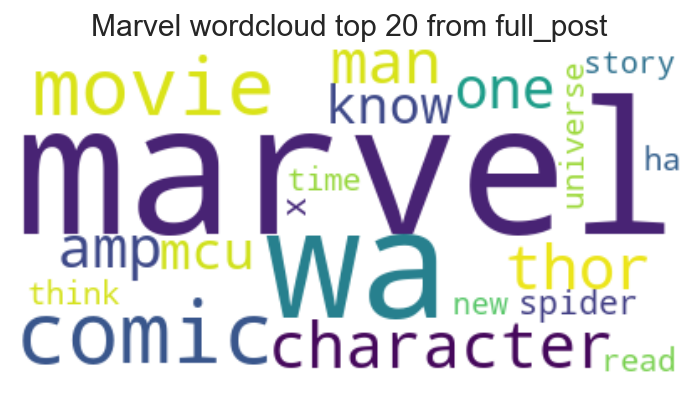

In [27]:
# plot Marvel wordcloud from `full_post`
show_cloud(marvel_cloud, title="Marvel wordcloud top 20 from full_post")

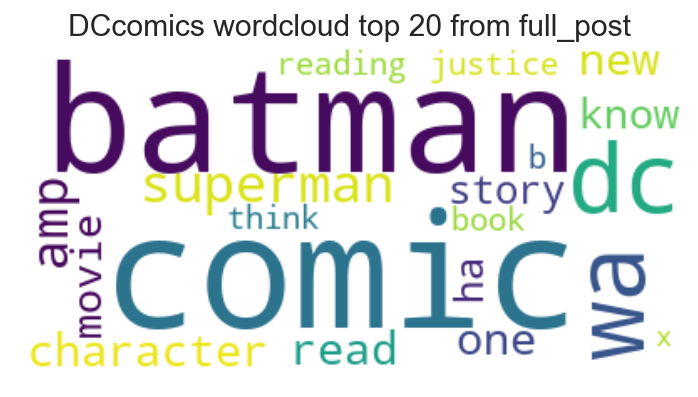

In [28]:
# plot DCcomics wordcloud from `full_post`
show_cloud(dcomics_cloud, title="DCcomics wordcloud top 20 from full_post")

In [29]:
# normalised frequency of `full_post` words descending
marvel_cloud.words_

{'marvel': 1.0,
 'wa': 0.9912170639899623,
 'comic': 0.7314930991217063,
 'movie': 0.6511919698870765,
 'character': 0.5407779171894604,
 'man': 0.5043914680050188,
 'thor': 0.4918444165621079,
 'amp': 0.4316185696361355,
 'one': 0.4190715181932246,
 'know': 0.4090338770388959,
 'mcu': 0.40526976160602257,
 'spider': 0.35257214554579674,
 'x': 0.35131744040150564,
 'think': 0.3174404015056462,
 'ha': 0.3136762860727729,
 'time': 0.3124215809284818,
 'universe': 0.3099121706398996,
 'read': 0.2961104140526976,
 'story': 0.27854454203262236,
 'new': 0.27854454203262236}

In [30]:
# normalised frequency of `full_post` words descending
dcomics_cloud.words_

{'comic': 1.0,
 'batman': 0.8549931600547196,
 'dc': 0.79890560875513,
 'wa': 0.7852257181942545,
 'superman': 0.6908344733242134,
 'amp': 0.6320109439124487,
 'new': 0.466484268125855,
 'character': 0.45964432284541723,
 'one': 0.4582763337893297,
 'read': 0.45690834473324216,
 'know': 0.4049247606019152,
 'movie': 0.39261285909712723,
 'story': 0.38303693570451436,
 'ha': 0.3734610123119015,
 'justice': 0.33652530779753764,
 'b': 0.3337893296853625,
 'book': 0.32558139534883723,
 'reading': 0.32147742818057456,
 'think': 0.3173734610123119,
 'x': 0.2667578659370725}

#### Comparing `post` feature:
---

In [31]:
# create bag of words for each dataframe 'marvel' and 'dcomics'
# based on feature 'post'
marvel_post = marvel_df['post'].apply(lemmatize_text)
dcomics_post = dcomics_df['post'].apply(lemmatize_text)

In [32]:
%%time
# group words in entire feature
marvel_text = bag_of_words(marvel_post)
dcomics_text = bag_of_words(dcomics_post)

CPU times: total: 42.6 s
Wall time: 43.3 s


In [33]:
# instantiate wordcloud
marvel_cloud = make_cloud(marvel_text, seed=2)

dcomics_cloud = make_cloud(dcomics_text, seed=2)

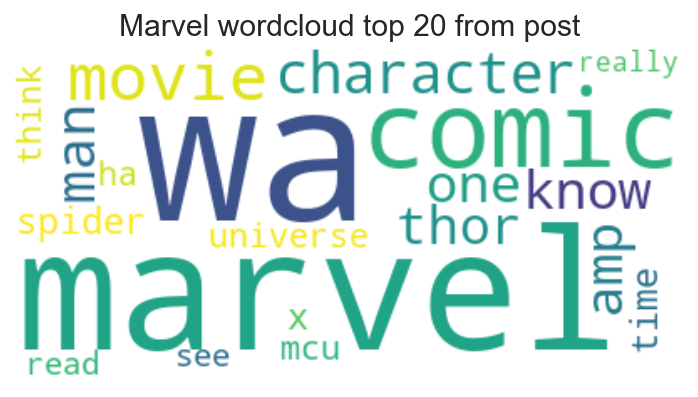

In [34]:
# plot Marvel wordcloud from `post`
show_cloud(marvel_cloud, title="Marvel wordcloud top 20 from post")

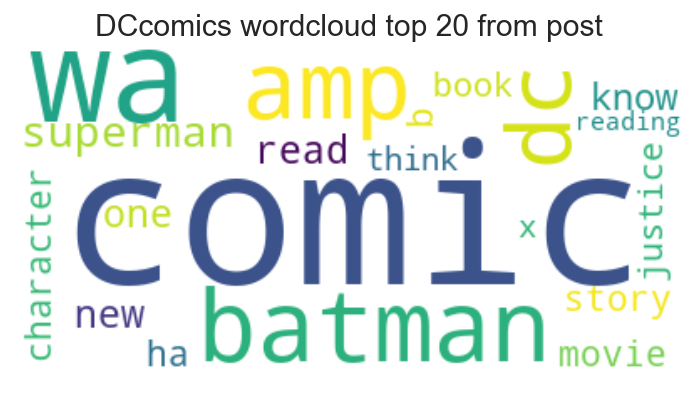

In [35]:
# plot DCcomics wordcloud from `post`
show_cloud(dcomics_cloud, title="DCcomics wordcloud top 20 from post")

In [36]:
# normalised frequency of `post` words descending
marvel_cloud.words_

{'wa': 1.0,
 'marvel': 0.7799736495388669,
 'comic': 0.6297760210803689,
 'movie': 0.6034255599472991,
 'character': 0.49407114624505927,
 'man': 0.4624505928853755,
 'amp': 0.4268774703557312,
 'one': 0.4189723320158103,
 'know': 0.40711462450592883,
 'thor': 0.38998682476943347,
 'spider': 0.308300395256917,
 'x': 0.3069828722002635,
 'time': 0.30303030303030304,
 'universe': 0.30039525691699603,
 'think': 0.30039525691699603,
 'mcu': 0.2964426877470356,
 'ha': 0.2951251646903821,
 'read': 0.2727272727272727,
 'see': 0.26613965744400525,
 'really': 0.2648221343873518}

In [37]:
# normalised frequency of `post` words descending
dcomics_cloud.words_

{'comic': 1.0,
 'wa': 0.9531531531531532,
 'batman': 0.9045045045045045,
 'amp': 0.8234234234234235,
 'dc': 0.7495495495495496,
 'superman': 0.7405405405405405,
 'one': 0.5441441441441441,
 'new': 0.5261261261261261,
 'read': 0.5243243243243243,
 'know': 0.4954954954954955,
 'character': 0.4720720720720721,
 'movie': 0.46846846846846846,
 'ha': 0.45765765765765765,
 'story': 0.44324324324324327,
 'b': 0.436036036036036,
 'justice': 0.3855855855855856,
 'book': 0.3747747747747748,
 'x': 0.3441441441441441,
 'think': 0.3387387387387387,
 'reading': 0.33513513513513515}

#### Comparing `title` feature:
---

In [38]:
# create bag of words for each dataframe 'marvel' and 'dcomics'
# based on feature 'post'
marvel_title = marvel_df['title'].apply(lemmatize_text)
dcomics_title = dcomics_df['title'].apply(lemmatize_text)

In [39]:
%%time
# group words in entire feature
marvel_text = bag_of_words(marvel_title)
dcomics_text = bag_of_words(dcomics_title)

CPU times: total: 4.45 s
Wall time: 4.5 s


In [40]:
# instantiate wordcloud
marvel_cloud = make_cloud(marvel_text, seed=3)

dcomics_cloud = make_cloud(dcomics_text, seed=3)

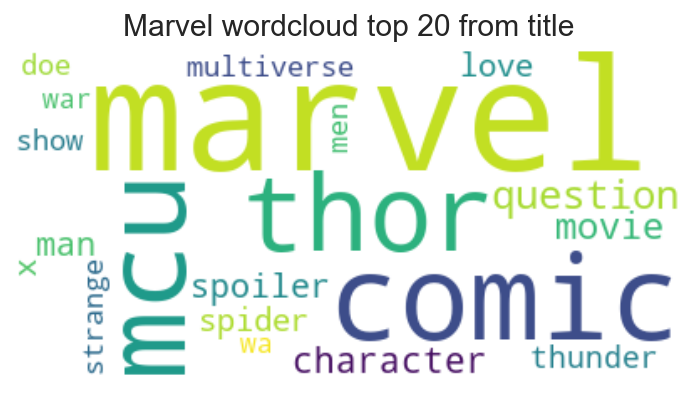

In [41]:
# plot wordcloud from `title`
show_cloud(marvel_cloud, title="Marvel wordcloud top 20 from title")

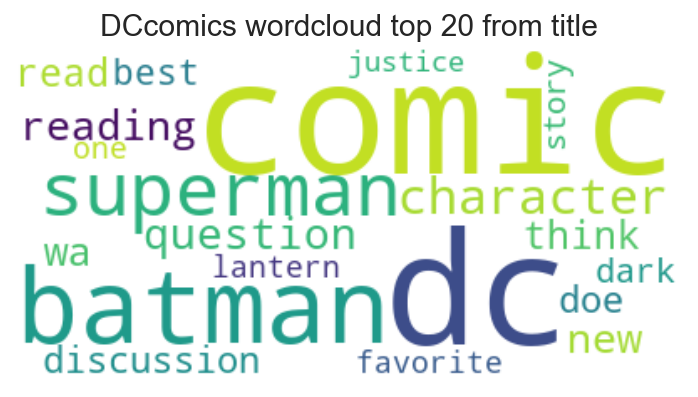

In [42]:
# plot wordcloud from `title`
show_cloud(dcomics_cloud, title="DCcomics wordcloud top 20 from title")

In [43]:
# normalised frequency of `title` words descending
marvel_cloud.words_

{'marvel': 1.0,
 'comic': 0.5121951219512195,
 'mcu': 0.47804878048780486,
 'thor': 0.4682926829268293,
 'question': 0.35609756097560974,
 'movie': 0.2975609756097561,
 'character': 0.2731707317073171,
 'spoiler': 0.25853658536585367,
 'man': 0.24878048780487805,
 'x': 0.22926829268292684,
 'spider': 0.22926829268292684,
 'love': 0.22439024390243903,
 'thunder': 0.2048780487804878,
 'show': 0.18536585365853658,
 'strange': 0.18536585365853658,
 'multiverse': 0.18048780487804877,
 'doe': 0.17073170731707318,
 'men': 0.16585365853658537,
 'war': 0.15609756097560976,
 'wa': 0.15121951219512195}

In [44]:
# normalised frequency of `title` words descending
dcomics_cloud.words_

{'comic': 1.0,
 'dc': 0.9545454545454546,
 'batman': 0.6988636363636364,
 'superman': 0.5340909090909091,
 'character': 0.42045454545454547,
 'question': 0.3125,
 'reading': 0.2784090909090909,
 'new': 0.2784090909090909,
 'wa': 0.2556818181818182,
 'think': 0.25,
 'read': 0.24431818181818182,
 'discussion': 0.23295454545454544,
 'doe': 0.23295454545454544,
 'best': 0.2215909090909091,
 'dark': 0.21022727272727273,
 'story': 0.19318181818181818,
 'favorite': 0.1875,
 'lantern': 0.1875,
 'one': 0.1875,
 'justice': 0.18181818181818182}

Based on what is observed from the word clouds, `title` and `post` contents are generally quite similar within each subreddit. My project aim is to build an NLP algorithm that identifies which subreddit a given post came from. To maximise the text data available, I will use **`full_post`** feature for my machine learning model. 

### Pre-Processing
---
__Tips:__
* [Tokenization for Out of Vocabulary words](https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/)
* [GloVe reference](https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/#:~:text=The%20basic%20idea%20behind%20the,pair%20of%20words%20occurring%20together.)

All data has to be converted to numerical before feeding into a machine learning model. However, because I am dealing with text as values (not categorical values), I cannot easily dummify, use one-hot or label encoding to convert the data before `train-test-split`. <br><br>
The only way to deal with this problem is to use word embeddings. This involves a few steps (remove special characters, tokenizing, lemmatizing/stemming, stop word removal). They can be done in separate steps, or in single step using transformers called word vectorizors. Fortunately, there has are many available transformers I can use, all with their own pros and cons. I start with CountVectorizer and TfidfVectorizer because they are basic and use less computation power. Other transformers include Word2Vec, GloVe, BERT. The other transformers are also pre-trained which makes them more useful for sentiment analysis or text query.

My plan is to use GridsearchCV to try different methods of word vectorisation with a range of parameters, paired with random forest classifier. Scoring will be via confusion matrix to get the 4 scores (accuracy, recall, specificity, f1 score). <br><br>
After that, I aim to use GridSearchCV again with the same methods of word vectorisation paired with different classifiers. 

### One-hot encoding of target `subreddit`
---

Convert `Marvel` and `DCcomics` into binary labels:
* 1 for `Marvel`
* 0 for `DCcomics`

In [45]:
# caution: re-runs of same cell will result in np.nan  
df['subreddit'] = df['subreddit'].map({'Marvel':1, 'DCcomics':0})
df.head(3)

,epoch_time,author,title,post,subreddit,full_post
0,1657980098,DarkUpquark,"Watched ""Helstrom"" on hulu",Missed that it actually made it to air in 2020...,1,"Watched ""Helstrom"" on hulu Missed that it actu..."
1,1657974418,CEO_of_Redd1t,Explaining why the MCU is Earth-616 now in the...,So there's been a lot of discussion lately abo...,1,Explaining why the MCU is Earth-616 now in the...
2,1657963597,Short-Step-6704,what should i watch first?,Guys i've never seen any movie from marvel.. s...,1,what should i watch first? Guys i've never see...


In [46]:
# export for possible deployment
df.to_csv('./data/tts.csv', index=False)

### Train-test-split `post`
---

Here, I am using `post` feature only. I can only use one feature at a time when pairing word vectorisation with an estimator in a pipeline because word vectorisation changes the shape of the `X_train` in ways that is not compatible with fitting with `y_train` during model fit.

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Step 1: Split into training & testing sets
X = df['post'] # pd.series because dataframe format not friendly for word vectorization
y = df['subreddit']

# make sure target variable has equal representation on both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2,
                                                    stratify=y, 
                                                    random_state=42)

In [49]:
X_train.shape

(1614,)

In [50]:
y_train.shape

(1614,)

In [51]:
y_train.value_counts()

0    808
1    806
Name: subreddit, dtype: int64

In [52]:
y_test.value_counts()

0    202
1    202
Name: subreddit, dtype: int64

### Tokenizing & Lemmatizing `post`
---
Text within the dataframe needs to be `tokenized` before lemmatizing can be applied.

Conduct lemming on text before applying to `CountVectorizer()` and `TfidfVectorizer()` since both word vectorizers do not include lemmatizing/stemming of words. (At least as far as I can understand from documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

__Reference:__ 
* [StackOverflow](https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells)

In [53]:
# function for tokenizing and lemming
def lemmatize_join(text):
    tokenizer = RegexpTokenizer('[a-z]+', gaps=False) # instantiate tokenizer
    lemmer = WordNetLemmatizer() # instantiate lemmatizer
    return ' '.join([lemmer.lemmatize(w) for w in tokenizer.tokenize(text.lower())]) 
    # lowercase, join back together with spaces so that word vectorizers can still operate 
    # on cell contents as strings

In [54]:
Z_train = X_train.apply(lemmatize_join) #apply function

In [55]:
Z_test = X_test.apply(lemmatize_join) # do the same for X_test set

In [56]:
Z_train.shape # double check shape did not change

(1614,)

In [57]:
print(Z_train[:2]) # check how first 2 cells look like now

1044    would love to hear something that isn t a well...
1971    ha anyone been having trouble with the google ...
Name: post, dtype: object


### GridSearch Random Forest Classifiers for `post`
---

Using Pipelines, CountVectorizer, TfidfVectorizer and GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

##### Instantiate Pipelines and GridSearchCV
[GridSearch + Pipeline multiple models reference](https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3)

In [59]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=1))
])

pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=1))
])

In [60]:
###### word vectorizors hyperparameters ######
features = [500, 1_000]
min_df = [2, 3] # A word must occur in at least {} documents from the corpus
max_df = [.6,.8] # Ignore words that occur in {} of the documents from the corpus
ngrams = [(1,2)] # capture {}-word phrases 
stop_words = ['english']
accent = ['unicode']

###### randomforestclassifiers hyperparameters ######
n_estimators = [20, 50, 100] # number of trees in the forest.
max_depth = [1, 2, 3] # maximum depth of the tree
min_split = [2, 3, 4, 5]# minimum number of samples required to split
seeds = [1,2,3]
      
cvec_rf_params = [{'cvec__max_features': features,
                   'cvec__min_df': min_df,
                   'cvec__max_df': max_df,
                   'cvec__ngram_range': ngrams,
                   'cvec__lowercase': [False],
                   'cvec__stop_words': stop_words,
                   'cvec__strip_accents': accent,
                   'rf__n_estimators': n_estimators,
                   'rf__max_depth': max_depth,
                   'rf__min_samples_split': min_split, 
                   'rf__n_jobs':[-2],
                   'rf__random_state': seeds}]

tvec_rf_params = [{'tvec__max_features': features,
                   'tvec__min_df': min_df,
                   'tvec__max_df': max_df,
                   'tvec__ngram_range': ngrams,
                   'tvec__lowercase': [False],
                   'tvec__stop_words': stop_words,
                   'tvec__strip_accents': accent,
                   'rf__n_estimators': n_estimators,
                   'rf__max_depth': max_depth,
                   'rf__min_samples_split': min_split,
                   'rf__n_jobs':[-2], 
                   'rf__random_state': seeds}]

In [61]:
cvec_rf_gs = GridSearchCV(pipe_cvec_rf,
                          cvec_rf_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1)

tvec_rf_gs = GridSearchCV(pipe_tvec_rf,
                          tvec_rf_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1)

In [62]:
%%time

import time
named_tuple = time.localtime() # get start_time
time_string = time.strftime("%d/%m/%Y, %H:%M", named_tuple) # format time print
print(f'start time: {time_string}')

# fit models
grids = [cvec_rf_gs, tvec_rf_gs]
for pipe in grids:
    pipe.fit(Z_train, y_train)

start time: 07/08/2022, 17:56
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: total: 52min 25s
Wall time: 52min 52s


### Evaluation of GridSearch Random Forest Classifier models for `post`:
---

* [Tune Prediction threshold](#Tune-prediction-threshold-for-GridSearch-Random-Forest-Classifier:)

In [63]:
from sklearn.metrics import (confusion_matrix, roc_auc_score, accuracy_score, 
                             recall_score, precision_score, f1_score)

#### Function for GridSearch models evaluation:
---

In [64]:
def model_summary_w_params(model, name, x_trn, x_tst):
    preds = model.predict(x_tst)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f'{name} test confusion matrix: \n {confusion_matrix(y_test, preds)}')
    print(f'{name} train accuracy: {model.score(x_trn,y_train):.3f}')
    print(f'{name} test accuracy: {model.score(x_tst,y_test):.3f}') # accuracy score
    print(f'{name} precision: {precision_score(y_test, preds):.3f}') #(tp / (tp + fp))
    print(f'{name} recall: {recall_score(y_test, preds):.3f}') # sensitivity (tp / (tp + fn))
    print(f'{name} f1 score: {f1_score(y_test, preds):.3f}') # aim precision = recall
    print(f'{name} specificity: {(tn / (tn + fp)):.3f}')
    print(f'{name} ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_tst)[:,1]):.3f}')
    print(f'{name} accuracy generalisation: {(((model.score(x_trn,y_train)-model.score(x_tst,y_test))*100)/model.score(x_trn,y_train)):.3f} %')
    print(f'{name} Best Params: {model.best_params_}')
    print()

In [65]:
grid_dict = {0: 'CvecRF', 1: 'TvecRF'} 
            
for i, model in enumerate(grids):
    model_summary_w_params(model=model,
                           name=grid_dict[i],
                           x_trn=Z_train,
                           x_tst=Z_test)

CvecRF test confusion matrix: 
 [[136  66]
 [  8 194]]
CvecRF train accuracy: 0.810
CvecRF test accuracy: 0.817
CvecRF precision: 0.746
CvecRF recall: 0.960
CvecRF f1 score: 0.840
CvecRF specificity: 0.673
CvecRF ROC AUC: 0.928
CvecRF accuracy generalisation: -0.870 %
CvecRF Best Params: {'cvec__lowercase': False, 'cvec__max_df': 0.6, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'cvec__strip_accents': 'unicode', 'rf__max_depth': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__n_jobs': -2, 'rf__random_state': 1}

TvecRF test confusion matrix: 
 [[137  65]
 [ 10 192]]
TvecRF train accuracy: 0.819
TvecRF test accuracy: 0.814
TvecRF precision: 0.747
TvecRF recall: 0.950
TvecRF f1 score: 0.837
TvecRF specificity: 0.678
TvecRF ROC AUC: 0.927
TvecRF accuracy generalisation: 0.577 %
TvecRF Best Params: {'rf__max_depth': 3, 'rf__min_samples_split': 4, 'rf__n_estimators': 100, 'rf__n_jobs': -2, 'rf__random_state': 1, 'tve

The average accuracy for both models hover around 80% with quite good ROC AUC score of around 0.9. I hope to increase the accuracy further by including `title` in model, as done in the following steps.

### Train-test-split `full_post`
---

Here, I am using `full_post` feature only. I can only use one feature at a time when pairing word vectorisation with an estimator in a pipeline because word vectorisation changes the shape of the `X_train` in ways that is not compatible with fitting with `y_train` during model fit.

In [66]:
# redefine X and y
X = df['full_post'] # pd.series because dataframe format not friendly for word vectorization
y = df['subreddit']

# make sure target variable has equal representation on both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2,
                                                    stratify=y, 
                                                    random_state=42)

In [67]:
X_train.shape

(1614,)

In [68]:
y_train.shape

(1614,)

In [69]:
y_train.value_counts() # check for imbalance

0    808
1    806
Name: subreddit, dtype: int64

In [70]:
y_test.value_counts() # check for imbalance

0    202
1    202
Name: subreddit, dtype: int64

### Tokenizing & Lemmatizing `full_post`
---
Text within the dataframe needs to be `tokenized` before lemmatizing can be applied.

Conduct lemming on text before applying to `CountVectorizer()` and `TfidfVectorizer()` since both word vectorizers do not include lemmatizing/stemming of words. (At least as far as I can understand from documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

__Reference:__ 
* [StackOverflow](https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells)

In [71]:
Z_train = X_train.apply(lemmatize_join) #apply function

In [72]:
Z_test = X_test.apply(lemmatize_join) # do the same for X_test set

In [73]:
Z_train.shape # double check shape did not change

(1614,)

In [74]:
print(Z_train[:2]) # check how first 2 cells look like now

1044    what are some of the character in the dc unive...
1971    google book dc comic ha anyone been having tro...
Name: full_post, dtype: object


### GridSearch Random Forest Classifiers for `full_post`
---

Using Pipelines, CountVectorizer, TfidfVectorizer and GridSearchCV

##### Instantiate Pipelines and GridSearchCV
[GridSearch + Pipeline multiple models reference](https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3)

In [75]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=1))
])

pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=1))
])

In [76]:
###### word vectorizors hyperparameters ######
features = [500, 1_000]
min_df = [2, 3] # A word must occur in at least {} documents from the corpus
max_df = [.6,.8] # Ignore words that occur in {} of the documents from the corpus
ngrams = [(1,2)] # capture {}-word phrases 
stop_words = ['english']
accent = ['unicode']

###### randomforestclassifiers hyperparameters ######
n_estimators = [20, 50, 100] # number of trees in the forest.
max_depth = [1, 2, 3] # maximum depth of the tree
min_split = [2, 3, 4, 5]# minimum number of samples required to split
seeds = [1,2,3]
      
cvec_rf_params = [{'cvec__max_features': features,
                   'cvec__min_df': min_df,
                   'cvec__max_df': max_df,
                   'cvec__ngram_range': ngrams,
                   'cvec__lowercase': [False],
                   'cvec__stop_words': stop_words,
                   'cvec__strip_accents': accent,
                   'rf__n_estimators': n_estimators,
                   'rf__max_depth': max_depth,
                   'rf__min_samples_split': min_split, 
                   'rf__n_jobs':[-2],
                   'rf__random_state': seeds}]

tvec_rf_params = [{'tvec__max_features': features,
                   'tvec__min_df': min_df,
                   'tvec__max_df': max_df,
                   'tvec__ngram_range': ngrams,
                   'tvec__lowercase': [False],
                   'tvec__stop_words': stop_words,
                   'tvec__strip_accents': accent,
                   'rf__n_estimators': n_estimators,
                   'rf__max_depth': max_depth,
                   'rf__min_samples_split': min_split,
                   'rf__n_jobs':[-2], 
                   'rf__random_state': seeds}]

In [77]:
cvec_rf_gs = GridSearchCV(pipe_cvec_rf,
                          cvec_rf_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1)

tvec_rf_gs = GridSearchCV(pipe_tvec_rf,
                          tvec_rf_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1)

In [78]:
%%time

import time
named_tuple = time.localtime() # get start_time
time_string = time.strftime("%d/%m/%Y, %H:%M", named_tuple) # format time print
print(f'start time: {time_string}')

# fit models
grids = [cvec_rf_gs, tvec_rf_gs]
for pipe in grids:
    pipe.fit(Z_train, y_train)

start time: 07/08/2022, 18:49
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: total: 56min 26s
Wall time: 56min 40s


### Evaluation of GridSearch Random Forest Classifier models for `full_post`:
---

* [Tune Prediction threshold](#Tune-prediction-threshold-for-GridSearch-Random-Forest-Classifier:)

#### Function for GridSearch models evaluation:
---

In [79]:
grid_dict = {0: 'CvecRF', 1: 'TvecRF'} 
            
for i, model in enumerate(grids):
    model_summary_w_params(model=model,
                           name=grid_dict[i],
                           x_trn=Z_train,
                           x_tst=Z_test)

CvecRF test confusion matrix: 
 [[164  38]
 [  7 195]]
CvecRF train accuracy: 0.901
CvecRF test accuracy: 0.889
CvecRF precision: 0.837
CvecRF recall: 0.965
CvecRF f1 score: 0.897
CvecRF specificity: 0.812
CvecRF ROC AUC: 0.969
CvecRF accuracy generalisation: 1.428 %
CvecRF Best Params: {'cvec__lowercase': False, 'cvec__max_df': 0.6, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'cvec__strip_accents': 'unicode', 'rf__max_depth': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__n_jobs': -2, 'rf__random_state': 3}

TvecRF test confusion matrix: 
 [[153  49]
 [  8 194]]
TvecRF train accuracy: 0.865
TvecRF test accuracy: 0.859
TvecRF precision: 0.798
TvecRF recall: 0.960
TvecRF f1 score: 0.872
TvecRF specificity: 0.757
TvecRF ROC AUC: 0.967
TvecRF accuracy generalisation: 0.696 %
TvecRF Best Params: {'rf__max_depth': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__n_jobs': -2, 'rf__random_state': 1, 'tvec

(Accuracy) The `Random Forest` classifier is able to **correctly** classify:
* 164 out of 202 `DC comic` posts
* 195 out of 202 `Marvel` posts

(Precision) Out of all posts classified as `Marvel` (233), 195 posts were correctly classified. <br> This gives a positive predictive value of 0.837.

(Recall) Out of all `Marvel` posts (202), 195 were correctly classified. 

(Specificity) Out of all `DC comics` posts (202), 164 were correctly classified. 

(F1 score) The weighted average of precision and recall is:<br>
> $2 * (0.837 * 0.965)/(0.837 + 0.965) = 0.896$ 

Based on the scores above, my `Random Forest` classifier is overall good at classifying between `Marvel` and `DC comics` subreddit posts, but better at identifying `Marvel` subreddit posts than `DC comics` posts. 

During the whole process of hyperparameter tuning, I had a lot of difficulty achieving generalisation of the Random Forest Classifier. Until I sought advice from my course instructor Justin Chan, who recommended for me to reduce _max depth_ to (1, 2), and maybe increase the _n\_estimators_ slightly if I reduce the _max depth_ drastically. 

Based on the `ROC AUC` (Receiver Operating Characteristic Curve) score, **`cvec_rf_gs`** model has a slightly superior performance than `tvec_rf_gs`. **`cvec_rf_gs`** also has good generalisation of 1.428%. Therefore, I will choose **`cvec_rf_gs`** for further tuning below.

### Tune prediction threshold for `GridSearch Random Forest` Classifier:
---

In [80]:
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [81]:
# threshold 0.3, view first 10 results
print(get_predictions(cvec_rf_gs.predict_proba(Z_test)[:,1], 0.3)[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [82]:
threshold_list = [0.25, 0.4, 0.5, 0.6, 0.75]

for threshold in threshold_list:
    preds = get_predictions(cvec_rf_gs.predict_proba(Z_test)[:,1], threshold)
    acc = accuracy_score(y_test, preds)
    print(f'Threshold: {threshold}, Accuracy: {acc}')

Threshold: 0.25, Accuracy: 0.5222772277227723
Threshold: 0.4, Accuracy: 0.6237623762376238
Threshold: 0.5, Accuracy: 0.8886138613861386
Threshold: 0.6, Accuracy: 0.6287128712871287
Threshold: 0.75, Accuracy: 0.5123762376237624


Probability threshold at 0.5 is optimal for model performance as expected since the dataset used for model has almost equal representation for each target class. Since the default classification setting is 0.5, there is no need for further tuning of probability threshold for the model.

### GridSearch Naive Bayes Classifiers
---

Using Pipelines, CountVectorizer, TfidfVectorizer and GridSearchCV.

Here I will use MultinomialNB instead of BernoulliNB because BernoulliNB only accepts binary word vectors, which TfidfVectorizer would not be compatible with.

In [83]:
from sklearn.naive_bayes import MultinomialNB

##### Instantiate Pipelines and GridSearchCV
[GridSearch + Pipeline multiple models reference](https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3)

In [84]:
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [85]:
###### word vectorizors hyperparameters ######
features = [500, 1_000]
min_df = [2, 3] # A word must occur in at least {} documents from the corpus
max_df = [.6,.8] # Ignore words that occur in {} of the documents from the corpus
ngrams = [(1,2)] # capture {}-word phrases 
stop_words = ['english']
accent = ['unicode']

###### naive bayes classifiers hyperparameters ######
alphas = [.5,1.] # Additive (Laplace/Lidstone) smoothing parameter.
      
cvec_nb_params = [{'cvec__max_features': features,
                   'cvec__min_df': min_df,
                   'cvec__max_df': max_df,
                   'cvec__ngram_range': ngrams,
                   'cvec__lowercase': [False],
                   'cvec__stop_words': stop_words,
                   'cvec__strip_accents': accent,
                   'nb__alpha': alphas
                   }]

tvec_nb_params = [{'tvec__max_features': features,
                   'tvec__min_df': min_df,
                   'tvec__max_df': max_df,
                   'tvec__ngram_range': ngrams,
                   'tvec__lowercase': [False],
                   'tvec__stop_words': stop_words,
                   'tvec__strip_accents': accent,
                   'nb__alpha': alphas
                   }]

In [86]:
cvec_nb_gs = GridSearchCV(pipe_cvec_nb,
                          cvec_nb_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-2)

tvec_nb_gs = GridSearchCV(pipe_tvec_nb,
                          tvec_nb_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-2)

In [87]:
%%time

import time
named_tuple = time.localtime() # get start_time
time_string = time.strftime("%d/%m/%Y, %H:%M", named_tuple) # format time print
print(f'start time: {time_string}')

# fit models
grids = [cvec_nb_gs, tvec_nb_gs]
for pipe in grids:
    pipe.fit(Z_train, y_train)

start time: 07/08/2022, 19:46
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 2.06 s
Wall time: 18.8 s


### Evaluation of GridSearch Naive Bayes Classifier models:
---

* [Tune Prediction threshold](#Tune-prediction-threshold-for-GridSearch-Naive-Bayes-Classifier:)

In [88]:
grid_dict = {0: 'CvecNB', 1: 'TvecNB'} 
            
for i, model in enumerate(grids):
    model_summary_w_params(model=model, # use constructed function
                           name=grid_dict[i],
                           x_trn=Z_train,
                           x_tst=Z_test)

CvecNB test confusion matrix: 
 [[183  19]
 [ 10 192]]
CvecNB train accuracy: 0.934
CvecNB test accuracy: 0.928
CvecNB precision: 0.910
CvecNB recall: 0.950
CvecNB f1 score: 0.930
CvecNB specificity: 0.906
CvecNB ROC AUC: 0.980
CvecNB accuracy generalisation: 0.588 %
CvecNB Best Params: {'cvec__lowercase': False, 'cvec__max_df': 0.6, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'cvec__strip_accents': 'unicode', 'nb__alpha': 0.5}

TvecNB test confusion matrix: 
 [[180  22]
 [ 14 188]]
TvecNB train accuracy: 0.942
TvecNB test accuracy: 0.911
TvecNB precision: 0.895
TvecNB recall: 0.931
TvecNB f1 score: 0.913
TvecNB specificity: 0.891
TvecNB ROC AUC: 0.974
TvecNB accuracy generalisation: 3.341 %
TvecNB Best Params: {'nb__alpha': 0.5, 'tvec__lowercase': False, 'tvec__max_df': 0.6, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__strip_accents': 'unicode'}



(Accuracy) The `MultinomialNB` classifier is able to **correctly** classify:
* 183 out of 202 `DC comic` posts
* 192 out of 202 `Marvel` posts

(Precision) Out of all posts classified as `Marvel` (211), 192 posts were correctly classified. <br> This gives a positive predictive value of 0.910.

(Recall) Out of all `Marvel` posts (202), 192 were correctly classified. 

(Specificity) Out of all `DC comics` posts (202), 183 were correctly classified. 

(F1 score) The weighted average of precision and recall is:<br>
> $2 * (0.910 * 0.950)/(0.910 + 0.950) = 0.930$ 

Based on the scores above, my `Multinomial Naive Bayes` classifier is overall good at classifying between `Marvel` and `DC comics` subreddit posts, but slightly better at identifying `Marvel` subreddit posts than `DC comics` posts. 

In comparison with my `Random Forest` classifier, my `MultinomialNB` model has a marginally poorer recall but superior specificity. F1 score, ROC AUC scores are also more superior. I would say my `MultinomialNB` model is the superior model compared to my `Random Forest` classifier. 

Based on the `ROC AUC` (Receiver Operating Characteristic Curve) score, **`cvec_nb_gs`** model has a slightly superior performance than `tvec_nb_gs`. **`cvec_nb_gs`** also has good generalisation of 0.588%. Therefore, I will choose **`cvec_nb_gs`** for further tuning below.

### Tune prediction threshold for GridSearch Naive Bayes Classifier:
---

In [89]:
# threshold 0.3, view first 10 results
print(get_predictions(cvec_nb_gs.predict_proba(Z_test)[:,1], 0.3)[:10])

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]


In [90]:
threshold_list = [0.25, 0.4, 0.5, 0.6, 0.75]

for threshold in threshold_list:
    preds = get_predictions(cvec_nb_gs.predict_proba(Z_test)[:,1], threshold)
    acc = accuracy_score(y_test, preds)
    print(f'Threshold: {threshold}, Accuracy: {acc}')

Threshold: 0.25, Accuracy: 0.9108910891089109
Threshold: 0.4, Accuracy: 0.9207920792079208
Threshold: 0.5, Accuracy: 0.9282178217821783
Threshold: 0.6, Accuracy: 0.9257425742574258
Threshold: 0.75, Accuracy: 0.9282178217821783


This is very interesting insight into Naive Bayes model performance. A wide variation of probability threshold has little effect on the accuracy of this model. <br><br>
Probability threshold of 0.5 and 0.75 have the highest accuracy scores. Since the default classification setting is 0.5, there is no need for further tuning of probability threshold for the model.

### Standalone Count Vectorization:
---

Doing this as an extra separate step is to get word vectorised data for [detailed evaluations](#Visualisations-for-models-comparison:) of _**GridSearchCV Random Forest classifier**_ and _**GridSearchCV Multinomial Naive Bayes**_ models respectively. 

In [91]:
# instantiate word vectorizer
cvec = CountVectorizer(lowercase=False, 
                       max_df=0.6, 
                       max_features=1000,
                       min_df=3,
                       ngram_range=(1,2),
                       stop_words='english',
                       strip_accents='unicode')

In [92]:
# Fit our CountVectorizer on the training data and transform training data.
Z_train_cvec = pd.DataFrame(cvec.fit_transform(Z_train).todense(),
                           columns=cvec.get_feature_names_out())

In [93]:
# Transform our testing data with the already-fit CountVectorizer.
Z_test_cvec = pd.DataFrame(cvec.transform(Z_test).todense(),
                           columns=cvec.get_feature_names_out())

In [94]:
Z_train_cvec.shape

(1614, 1000)

In [95]:
Z_train_cvec.head(3)

,ability,able,absolutely,act,action,action comic,actor,actual,actually,adam,...,www youtube,yeah,year,year ago,yellow,yes,young,young justice,youtube,youtube com
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [96]:
Z_train.to_csv('data/Z_train.csv', index=False) # for transformer fit in another notebook

In [97]:
# export Z_train_cvec to explore vocabulary that is fitted to model
Z_train_cvec.to_csv('data/train_cvec.csv', index=False)

### Visualisations for models comparison:
---

1. [Feature importance](#Feature-importance:)
1. [Confusion Matrix](#Confusion-matrices:)
1. [Probability distribution](#Probability-distribution-histograms) 
1. [Receiver Operating Characteristic (ROC) Curve](#Receiver-Operating-Characteristic-(ROC)-Curves)
1. [Precision Recall Curve](#Precision-Recall-Curves)

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay 

In [99]:
# isolate models from GridSearchCV for evaluation
rf_model = cvec_rf_gs.best_estimator_.named_steps['rf']
nb_model = cvec_nb_gs.best_estimator_.named_steps['nb']

### Feature importance:
---
1. [Random Forest classifier](#Random-Forest-classifier-feature-importance:)
1. [Multinomial NB classifier](#Multinomial-Naive-Bayes-classifier-feature-importance:)

__References:__
* [Concept reference](https://levelup.gitconnected.com/classifying-reddit-posts-with-natural-language-processing-and-random-forest-classifier-af2d8fa77bd3)
* [Plot reference](https://vitalflux.com/feature-importance-random-forest-classifier-python/)

#### Random Forest classifier feature importance:
---

In [100]:
# random forest classifier attribute
# order as arranged in training data
importances = rf_model.feature_importances_

# sort in descending order
high_importance = (np.argsort(importances)[::-1])[:10] #top 10 most important features to rf_model

In [101]:
print(importances[high_importance])

[0.05529628 0.04886209 0.04421688 0.03769917 0.035787   0.02921442
 0.02853161 0.02707727 0.0265319  0.02365534]


In [102]:
def barh(title, y, x, dec, limit):  
    fig, ax = plt.subplots() 
    plt.title(f'{title} Feature Importance', fontsize=13) # title

    hbars = plt.barh(y=y[::-1], # to arrange highest to lowest
                 width=x[::-1], # to arrange highest to lowest
                 align='center')

    ax.bar_label(hbars, fmt=dec, padding=2) # annotate each horizontal bar as subplot
    plt.xlim([0, limit]) # expand figure to fit annotations
    plt.xticks(rotation=45);

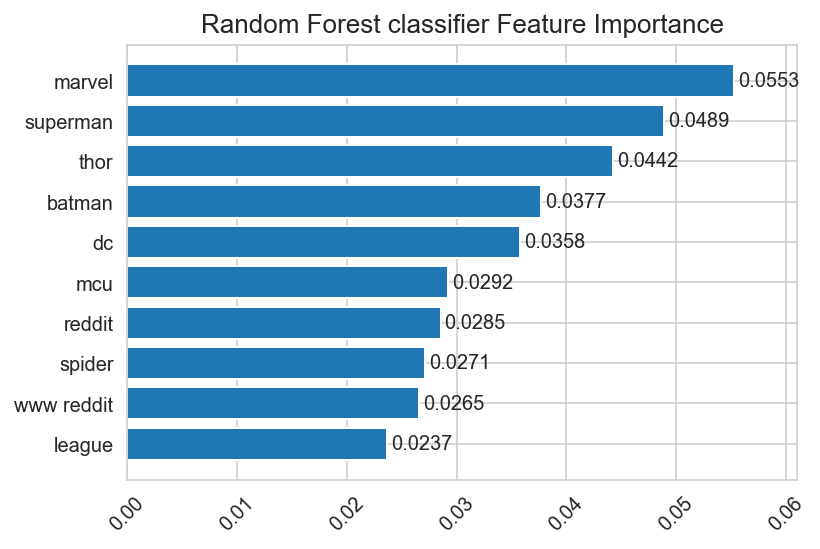

In [103]:
barh(title='Random Forest classifier', 
     y=Z_train_cvec.columns[high_importance],
     x=importances[high_importance],
     dec='%.4f',
     limit=0.061)

It is interesting to see that `www reddit` and `reddit` are important features (based on _gini impurity_) to the random forest classifier for differentiation. Perhaps this contributes to some generalisation. `league`, `dc`, `batman` and `superman` are features found in `DC comics` subreddit, while `spider`, `mcu`, `thor` and `marvel` would be features found in `Marvel` subreddit. There is good representation of important features from both subreddits. 

#### Multinomial Naive Bayes classifier feature importance:
---
__References:__
1. [Get feature importance in Naive Bayes](https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes)

In [104]:
dcomics_feature_indices = (nb_model.feature_log_prob_[0, :].argsort()[::-1])[:10]
marvel_feature_indices = (nb_model.feature_log_prob_[1, :].argsort()[::-1])[:10]

dcomics_impt_features = np.take(cvec.get_feature_names_out(), dcomics_feature_indices)
marvel_impt_features = np.take(cvec.get_feature_names_out(), marvel_feature_indices)

print(f'DCcomics top 10 features: \n {dcomics_impt_features}')
print()
print(f'Marvel top 10 features: \n {marvel_impt_features}')

DCcomics top 10 features: 
 ['comic' 'dc' 'batman' 'wa' 'amp' 'superman' 'just' 'like' 'http' 'read']

Marvel top 10 features: 
 ['marvel' 'wa' 'comic' 'like' 'movie' 'just' 'character' 'thor' 'amp'
 'man']


In [105]:
# isolate the log probabilities of the top 10 features for 
# convert to actual probability values for interpretability using np.exp()
# DC comics
dcomics_prob = np.exp(nb_model.feature_log_prob_[0, :][dcomics_feature_indices])

# Marvel
marvel_prob = np.exp(nb_model.feature_log_prob_[1, :][marvel_feature_indices])

In [106]:
marvel_prob

array([0.02129313, 0.02081748, 0.01555365, 0.01453894, 0.01438039,
       0.01317542, 0.01171677, 0.00940195, 0.00933853, 0.00908486])

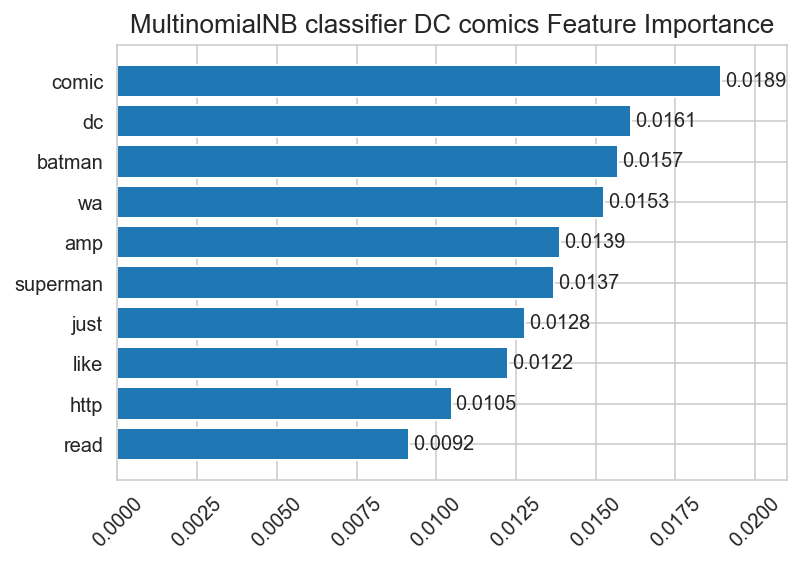

In [107]:
barh(title='MultinomialNB classifier DC comics', 
     y=dcomics_impt_features,
     x=dcomics_prob,
     dec='%.4f',
     limit=0.021)

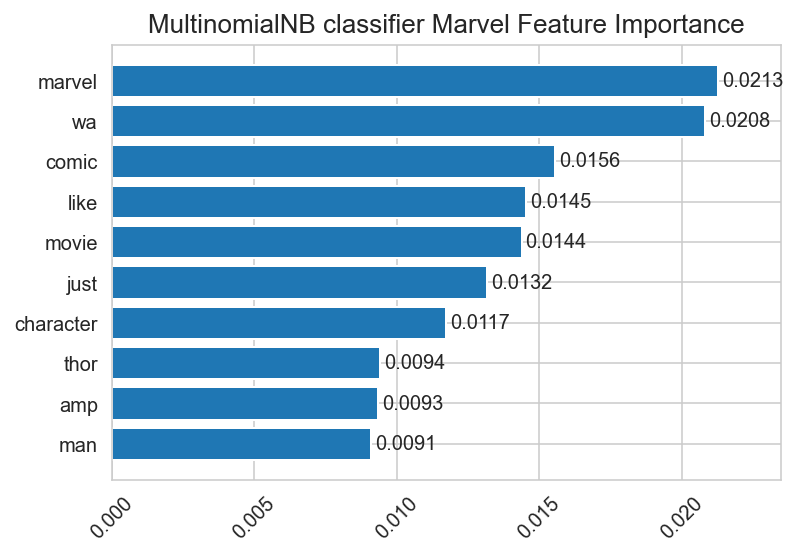

In [108]:
barh(title='MultinomialNB classifier Marvel', 
     y=marvel_impt_features,
     x=marvel_prob,
     dec='%.4f',
     limit=0.0235)

It is interesting to note that the highest actual probability for a single feature/word for either `Marvel` or `DCcomics` is around 0.02 for **`MultinomialNB classifier`**. It means that the strength of the classification algorithm relies on the cumulative probabilities and specific feature combinations. 

### Confusion matrices:
---

1. [Random Forest classifier](#GridSearchCV-Random-Forest-classifer-confusion-matrix:)<br>
1. [MultinomialNB classifier](#GridSearchCV-Multinomial-Naive-Bayes-classifer-confusion-matrix:)

#### GridSearchCV Random Forest classifer confusion matrix:
---

In [109]:
# function to plot confusion matrix
def matrix(model, y_set, X_set):
    confusion_mat = confusion_matrix(y_set, model.predict(X_set.values))
    ConfusionMatrixDisplay(confusion_mat, display_labels=['DCcomics','Marvel']).plot(cmap=plt.cm.Blues)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.grid(False); # hide grid

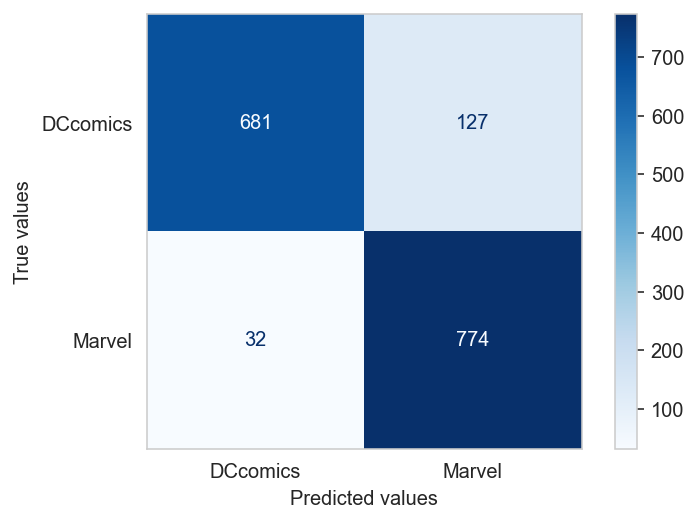

In [110]:
# confusion matrix on train set
matrix(model=rf_model,
       y_set=y_train,
       X_set=Z_train_cvec)

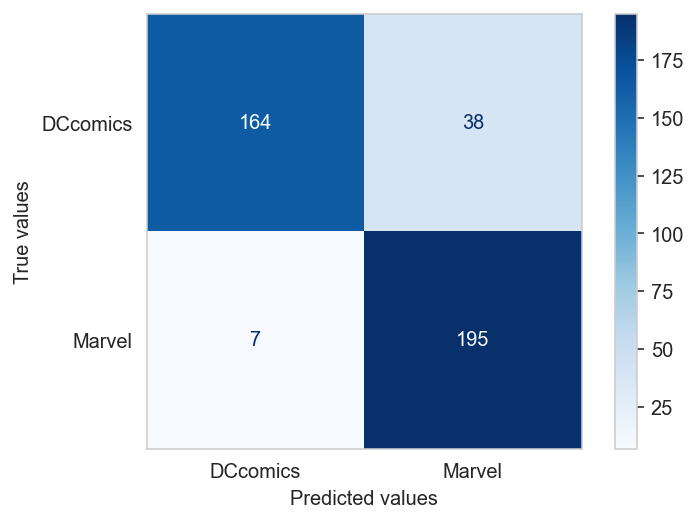

In [111]:
# confusion matrix on test set
matrix(model=rf_model, 
       y_set=y_test, 
       X_set=Z_test_cvec)

#### GridSearchCV Multinomial Naive Bayes classifer confusion matrix:
---

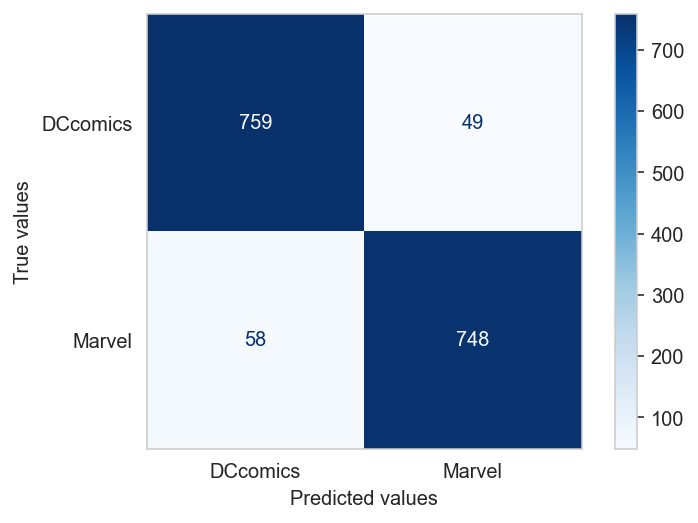

In [112]:
# confusion matrix on train set
matrix(model=nb_model,
       y_set=y_train,
       X_set=Z_train_cvec)

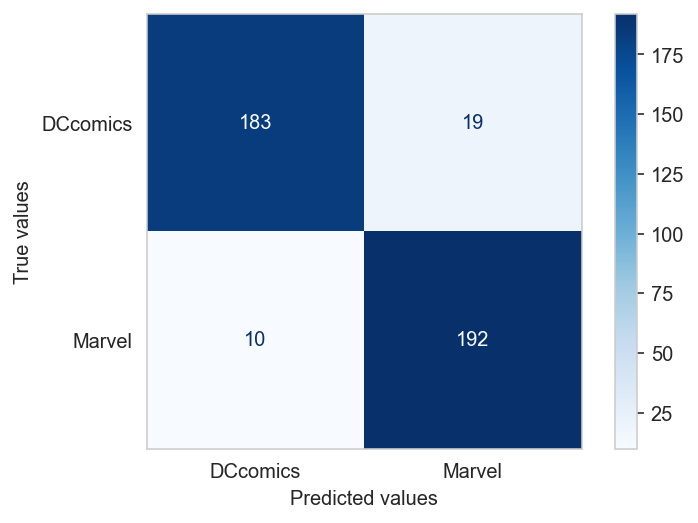

In [113]:
# confusion matrix on test set
matrix(model=nb_model,
       y_set=y_test, 
       X_set=Z_test_cvec)

### Probability distribution histograms
---
Use for identifying distribution of false positives and false negatives and how much they overlap. <br>
* [Random Forest classifier](#Random-Forest-Probability-distribution-with-threshold-0.5:)
* [Multinomial Naive Bayes classifier](#MultinomialNB-Probability-distribution-with-threshold-0.5:)

#### Random Forest Probability distribution with threshold 0.5: 
---

In [114]:
# create dataframe called rf_pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.
# 1 = 'Marvel', 0 = 'DCcomics'

rf_pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': rf_model.predict_proba(Z_test_cvec.values)[:,1]})

rf_pred_df.head(3)

,true_values,pred_probs
1574,0,0.482220
1771,0,0.319268
984,1,0.541272


In [172]:
# function to construct histogram to show probability distribution for each model
def histogram(df, TN, FN, FP, TP, title):
    
    plt.figure(figsize = (12, 5))

    # plot distributions of predicted probabilities by actual values
    ax = sns.histplot(data=df, x='pred_probs', hue='true_values')

    # Add cutoff line at threshold 0.5
    plt.axvline(0.5, color = 'black', linestyle = '--')

    # Add annotations for TN, FN, TP, FP.
    plt.annotate(xy=TN, text='TN', size=15)
    plt.annotate(xy=FN, text='FN', size=15)
    plt.annotate(xy=FP, text='FP', size=15)
    plt.annotate(xy=TP, text='TP', size=15)

    plt.xlabel('Predicted Probability that Outcome = 1', fontsize=13)

    # for legend text
    plt.setp(ax.get_legend().get_texts(), fontsize='15') 
 
    # for legend title
    plt.setp(ax.get_legend().get_title(), fontsize='15')
    
    # to move legend position outside
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    # add fig title
    plt.title(f'{title} model predicted probabilities distribution', fontsize=15); 

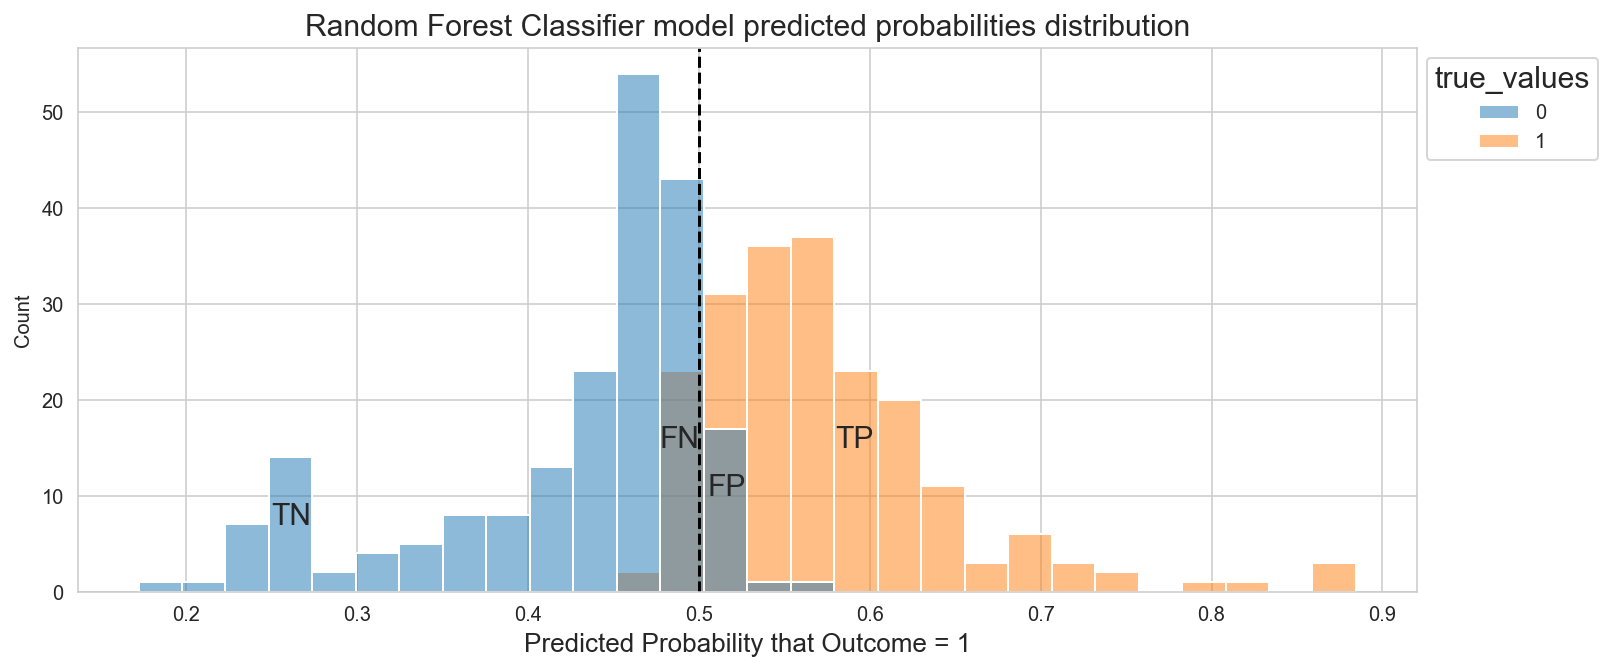

In [173]:
histogram(df=rf_pred_df, 
          TN=(0.25, 7), 
          FN=(0.477, 15),
          FP=(0.505, 10),
          TP=(0.58, 15),
          title='Random Forest Classifier')

#### MultinomialNB Probability distribution with threshold 0.5: 
---

In [117]:
# create dataframe called nb_pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.
# 1 = 'Marvel', 0 = 'DCcomics'

nb_pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': nb_model.predict_proba(Z_test_cvec.values)[:,1]})

nb_pred_df.head(3)

,true_values,pred_probs
1574,0,1.207793e-06
1771,0,1.612853e-31
984,1,9.998091e-01


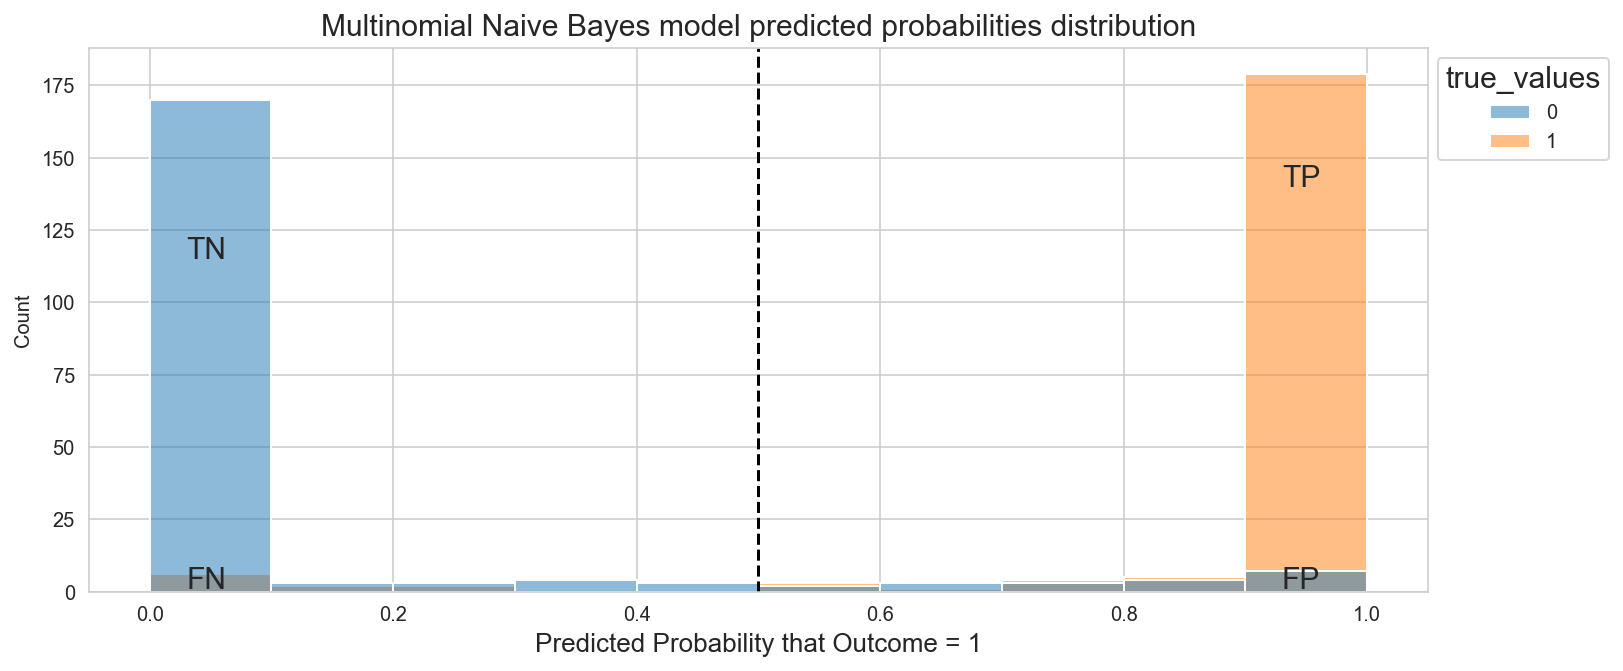

In [174]:
histogram(df=nb_pred_df, 
          TN=(0.03, 115), 
          FN=(0.03, 1),
          FP=(0.93, 1),
          TP=(0.93, 140),
          title='Multinomial Naive Bayes')

The histograms reveal an interesting pattern. 

There is a lot of overlap in predicted classes for `Random Forest` classifier. Most of the predicted probabilities also lie around the central part, between 0.4 and 0.6. Almost a normal distribution in probability values! It is a very narrow fight between 2 classes based on the probability assigned to a subreddit post. This also explains why threshold of 0.5 is critical for optimal performance of this model. 

Whereas for the `Multinomial Naive Bayes` classifier, there is a lot more certainty in predicted probabilities to differentiate subreddit posts. There is minimal overlap of classes. It is also curious to see that a large proportion of wrongly classified posts lie in the 2 extreme ends of probability range. I would be keen to find out more about these posts that were wrongly classified by this model - what attributes contributed to their wrong classification? That would help with defining the limitations of the model for this particular dataset. It would also be a guide on how to improve the model accuracy further.

One thing to consider, there is usually a tradeoff between sensitivity and specificity.

### Receiver Operating Characteristic (ROC) Curves
---
True Positive Rate vs. False Positive Rate for the range of possible decision thresholds
* [StackOverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python)

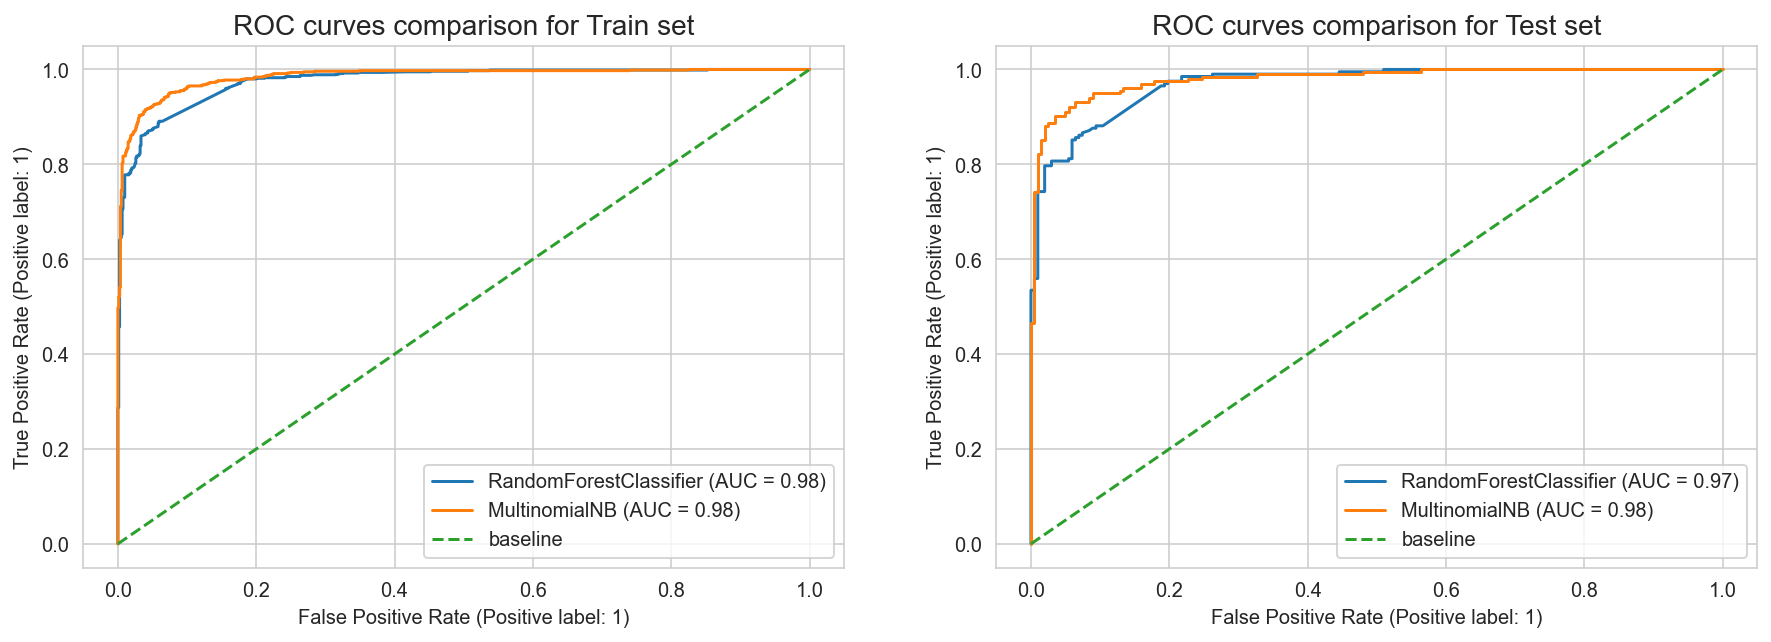

In [119]:
# format subplots
fig, ax = plt.subplots(1, 2, figsize=(15,4.8))

# first subplot on ax[0]
RocCurveDisplay.from_estimator(rf_model, Z_train_cvec.values, y_train, ax=ax[0])
RocCurveDisplay.from_estimator(nb_model, Z_train_cvec.values, y_train, ax=ax[0])
ax[0].plot([0, 1], [0, 1], label='baseline', linestyle='--') # plots baseline line
# baseline is 0.5 based on dataset class proportions
ax[0].set_title("ROC curves comparison for Train set", fontsize=14)
ax[0].legend() # includes baseline in legend

# second subplot on ax[1]
RocCurveDisplay.from_estimator(rf_model, Z_test_cvec.values, y_test, ax=ax[1])
RocCurveDisplay.from_estimator(nb_model, Z_test_cvec.values, y_test, ax=ax[1])
ax[1].plot([0, 1], [0, 1], label='baseline', linestyle='--')
ax[1].set_title("ROC curves comparison for Test set", fontsize=14)
ax[1].legend();

In [120]:
# check generalisation of ROC AUC curve
test_roc_score = roc_auc_score(y_test, model.predict_proba(Z_test)[:,1])
train_roc_score = roc_auc_score(y_train, model.predict_proba(Z_train)[:,1])
generalisation_score = (train_roc_score - test_roc_score)*100/train_roc_score
print('ROC AUC generalisation score is:', generalisation_score)

ROC AUC generalisation score is: 1.3654520603475522


Based on the plotted ROC curves, my `Random Forest classifier` ROC AUC score is 0.97 and my `MultinomialNB classifier` ROC AUC score is 0.98. The scores signify that the models are generally good at differentiating the 2 classes of subreddit posts (`DC comics` and `Marvel`). 

However as we already know from prior analysis above, the **`MultinomialNB classifier`** is the superior model with less overlapping predicted probabilities.

### Precision Recall Curves
---

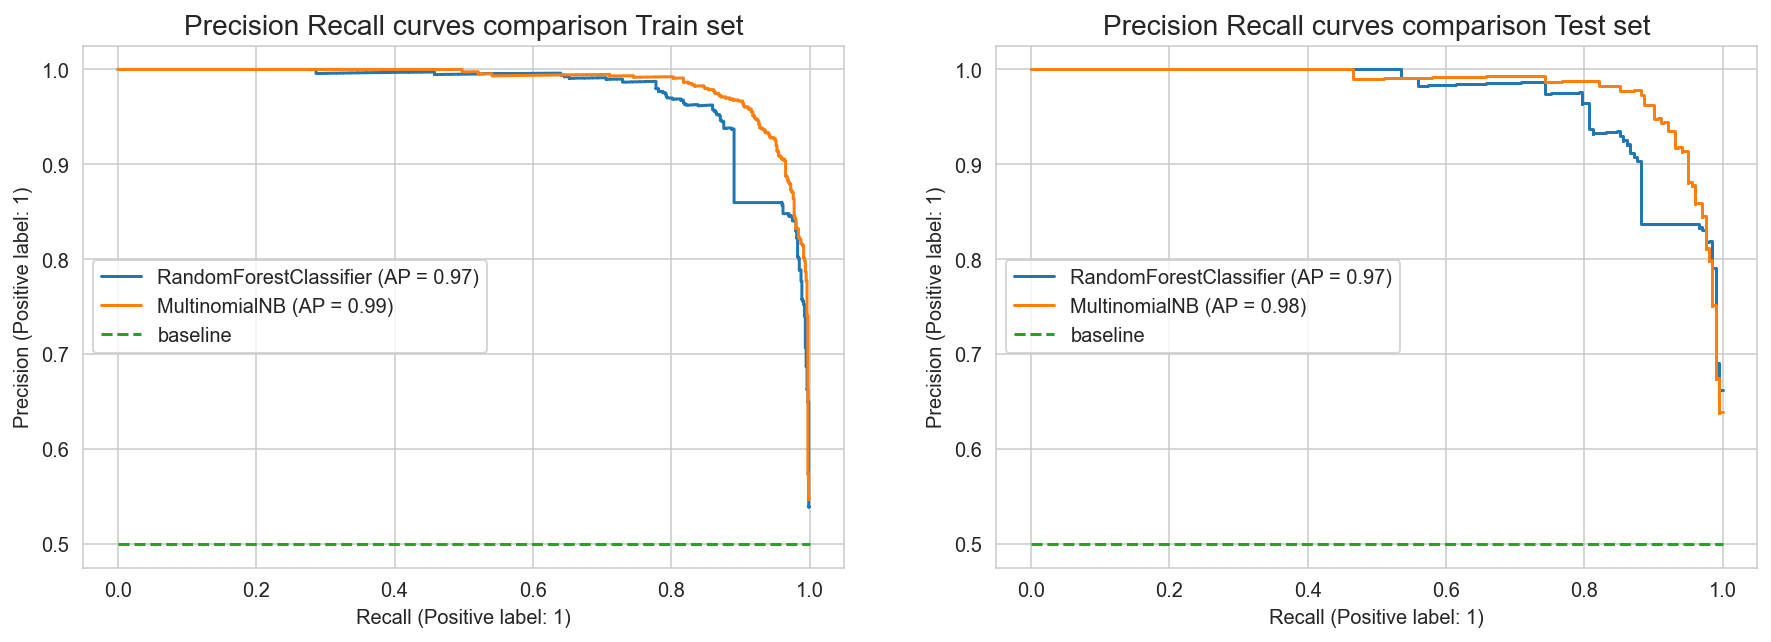

In [121]:
# format subplots
fig, ax = plt.subplots(1, 2, figsize=(15,4.8))

# first subplot on ax[0]
PrecisionRecallDisplay.from_estimator(rf_model, Z_train_cvec.values, y_train, ax=ax[0])
PrecisionRecallDisplay.from_estimator(nb_model, Z_train_cvec.values, y_train, ax=ax[0])
ax[0].plot([0,1], [.5,.5], label='baseline', linestyle='--') # plots baseline line,
# baseline is 0.5 based on dataset class proportions
ax[0].set_title("Precision Recall curves comparison Train set", fontsize=14)
ax[0].legend() # includes baseline in legend

# second subplot
PrecisionRecallDisplay.from_estimator(rf_model, Z_test_cvec.values, y_test, ax=ax[1])
PrecisionRecallDisplay.from_estimator(nb_model, Z_test_cvec.values, y_test, ax=ax[1])
ax[1].plot([0,1], [.5,.5], label='baseline', linestyle='--')
ax[1].set_title("Precision Recall curves comparison Test set", fontsize=14)
ax[1].legend();

AP score as shown in the Precision Recall curve is the **`average precision (AP)`** score. It is also **`area-under-curve (AUC-PR)`** using precision and recall scores. AP is calculated using average difference of all the test data labels and the classifier’s test prediction probabilities. The aim is to get the scores as close to 1 as possible. Here, MultinomialNB model is again superior to Random Forest Classifier. 

[Reference](https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248#:~:text=average_precision_score%20states%2C%20%E2%80%9CAP%20summarizes%20a,average%20precision%20across%20all%20thresholds.)

In [122]:
# precision score rf model, train set
preds = rf_model.predict(Z_train_cvec.values)
round(precision_score(y_train, preds), 4)

0.859

In [123]:
# generalisation rf model precision
preds = rf_model.predict(Z_test_cvec.values)
(0.859-precision_score(y_test, preds))*100/0.859

2.5716098667479343

In [124]:
# precision score nb model, train set
preds = nb_model.predict(Z_train_cvec.values)
round(precision_score(y_train, preds), 4)

0.9385

In [125]:
# nb model precision generalisation
(precision_score(y_train, preds)-0.91)*100/precision_score(y_train, preds)

3.038770053475933

In [126]:
# rf model recall score train
preds = rf_model.predict(Z_train_cvec.values)
round(recall_score(y_train, preds), 4)

0.9603

In [127]:
# rf model recall generalisation
trn_pred = rf_model.predict(Z_train_cvec.values)
tst_pred = rf_model.predict(Z_test_cvec.values)
(recall_score(y_train, trn_pred)-recall_score(y_test, tst_pred))*100/recall_score(y_train, trn_pred)

-0.5257502494435502

In [128]:
# nb model recall train set
preds = nb_model.predict(Z_train_cvec.values)
round(recall_score(y_train, preds), 4)

0.928

In [129]:
# nb model recall generalisation
preds = nb_model.predict(Z_test_cvec.values)
(0.928-recall_score(y_test, preds))*100/0.928

-2.424035506998966

In [130]:
# rf f1 score train set
preds = rf_model.predict(Z_train_cvec.values)
round(f1_score(y_train, preds), 4)

0.9069

In [131]:
# rf f1 score generalisation
trn_pred = rf_model.predict(Z_train_cvec.values)
tst_pred = rf_model.predict(Z_test_cvec.values)
(f1_score(y_train, trn_pred)-f1_score(y_test, tst_pred))*100/f1_score(y_train, trn_pred)

1.136059877038224

In [132]:
# nb f1 score train set
preds = nb_model.predict(Z_train_cvec.values)
round(f1_score(y_train, preds), 4)

0.9333

In [133]:
# nb f1 score generalisation
trn_pred = nb_model.predict(Z_train_cvec.values)
tst_pred = nb_model.predict(Z_test_cvec.values)
(f1_score(y_train, trn_pred)-f1_score(y_test, tst_pred))*100/f1_score(y_train, trn_pred)

0.37161243542102906

In [134]:
# rf specificity train set
preds = rf_model.predict(Z_train_cvec.values)
tn, fp, fn, tp = confusion_matrix(y_train, preds).ravel()
print(round((tn / (tn + fp)), 4))

0.8428


In [135]:
# rf specificity generalisation
trn_pred = rf_model.predict(Z_train_cvec.values)
tst_pred = rf_model.predict(Z_test_cvec.values)
tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_train, trn_pred).ravel()
tn_j, fp_j, fn_j, tp_j = confusion_matrix(y_test, tst_pred).ravel()
trn_sp = tn_i/(tn_i + fp_i)
tst_sp = tn_j/(tn_j + fp_j)
print((trn_sp-tst_sp)*100/trn_sp)

3.6710719530102693


In [136]:
# nb specificity train set
preds = nb_model.predict(Z_train_cvec.values)
tn, fp, fn, tp = confusion_matrix(y_train, preds).ravel()
print(round((tn / (tn + fp)), 4))

0.9394


In [137]:
# nb specificity generalisation
trn_pred = nb_model.predict(Z_train_cvec.values)
tst_pred = nb_model.predict(Z_test_cvec.values)
tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_train, trn_pred).ravel()
tn_j, fp_j, fn_j, tp_j = confusion_matrix(y_test, tst_pred).ravel()
trn_sp = tn_i/(tn_i + fp_i)
tst_sp = tn_j/(tn_j + fp_j)
print((trn_sp-tst_sp)*100/trn_sp)

3.5573122529644183


In [139]:
# rf roc auc score train set
roc_auc_score(y_train, rf_model.predict_proba(Z_train_cvec.values)[:,1])

0.9761058767167039

In [140]:
# rf roc auc generalisation 
roc_trn = roc_auc_score(y_train, rf_model.predict_proba(Z_train_cvec.values)[:,1])
roc_tst = roc_auc_score(y_test, rf_model.predict_proba(Z_test_cvec.values)[:,1])
print((roc_trn-roc_tst)*100/roc_trn)

0.6930227369042615


In [141]:
# nb roc auc score train set
roc_auc_score(y_train, nb_model.predict_proba(Z_train_cvec.values)[:,1])

0.9847393005429574

In [142]:
# nb roc auc generalisation 
roc_trn = roc_auc_score(y_train, nb_model.predict_proba(Z_train_cvec.values)[:,1])
roc_tst = roc_auc_score(y_test, nb_model.predict_proba(Z_test_cvec.values)[:,1])
print((roc_trn-roc_tst)*100/roc_trn)

0.4910304232940884


### Summary of evaluation metrics

|Data set|Evaluation metric|model|RF score|   |model|NB score|
|:-------|:---------------:|:---:|:-------|---|:---:|:-------|
|Train   |**Confusion matrix**|RF|[[681, 127],<br>[32, 774]]||NB|[[759, 49],<br>[58, 748]]|
|Test    |**Confusion matrix**|RF|[[164, 38],<br>[7, 195]]||NB|[[183, 19],<br>[10, 192]]|
|Train   |**Accuracy**        |RF|0.9015  |   |NB   |0.9337  |
|Test    |**Accuracy**        |RF|0.8886  |   |NB   |0.9282  |
|-       |**Accuracy generalisation**|RF|1.428 %||NB|0.588 % |
|Train   |**Precision**       |RF|0.859   |   |NB   |0.9385  |
|Test    |**Precision**       |RF|0.8369  |   |NB   |0.91    |
|-       |**Precision generalisation**|RF|2.572 %||NB|3.039% |
|Train   |**Recall**          |RF|0.9603  |   |NB   |0.928   |
|Test    |**Recall**          |RF|0.9653  |   |NB   |0.9505  |
|-       |**Recall generalisation**|RF|-0.526 %||NB |-2.424 %|
|Train   |**f1 score**        |RF|0.9069  |   |NB   |0.9333  |
|Test    |**f1 score**        |RF|0.8966  |   |NB   |0.9298  |
|-       |**f1 score generalisation**|RF|1.136 %||NB|0.372 % |
|Train   |**Specificity**     |RF|0.8428  |   |NB   |0.9394  |
|Test    |**Specificity**     |RF|0.8119  |   |NB   |0.9059  |
|-       |**Specificity generalisation**|RF|3.671 %||NB|3.557 %|
|Train   |**ROC AUC score**   |RF|0.9761  |   |NB   |0.9847  |
|Test    |**ROC AUC score**   |RF|0.9693  |   |NB   |0.9799  |
|-       |**ROC AUC generalisation**|RF|0.693 %||NB |0.491 % |

### Multicollinearity check
---

In [143]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

[Source Code VIF](https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python)

In [145]:
%%time 

# runtime around 15 min
# had warnings for zeros double scalar due to word vectors, R-square != 1 to resolve that
# to exclude infinity vif values from 1/1-R^2 using r-squared values
# equation from VIF source code
def r_sq(X_add_constant, i): # r-squared scores
    return sm.OLS((X_add_constant.values[:, i]), (X_add_constant.values[:, (np.arange(X_add_constant.shape[1]) != i)])).fit().rsquared

# checking only within the Z_train_cvec set
X_add_constant = add_constant(Z_train_cvec)

# make dataframe, sorted highest to lowest VIF
mcl_df = pd.DataFrame()
mcl_df["feature"] = X_add_constant.columns
vif = variance_inflation_factor(X_add_constant.values, i)
mcl_df['vif'] = sorted([vif if r_sq(X_add_constant, i)!=1 else 100 
                        for i in range(X_add_constant.shape[1])], 
                       reverse=True)

CPU times: total: 50min 19s
Wall time: 12min 39s


In [146]:
# show lowest 5
mcl_df.tail()

,feature,vif
996,yes,7.307419
997,young,7.307419
998,young justice,7.307419
999,youtube,7.307419
1000,youtube com,7.307419


Checking for multicollinearity in this dataset does not seem to be a useful venture based on the vif results. The scores also seem to be related with the alphabetical order of words.

### Explore wrongly classified `full_post` 
---

* [Random Forest classifier](#By-Random-Forest-classifier:)
* [Multinomial NB classifier](#By-Multinomial-Naive-Bayes-classifier:)

#### By Random Forest classifier:
---

In [147]:
# find the points that were wrongly classified by Random forest
rf_wrongclass = rf_pred_df.loc[((rf_pred_df['true_values']==1) & 
                                (rf_pred_df['pred_probs']<0.5))|
                                ((rf_pred_df['true_values']==0) & 
                                (rf_pred_df['pred_probs']>0.5))]
display(rf_wrongclass.head(3))

,true_values,pred_probs
1572,0,0.514977
1780,0,0.501310
1622,0,0.501310


In [148]:
# row indices classified wrongly in the test set by Random Forest 
rf_wrongclass_indices = rf_pred_df.index[((rf_pred_df['true_values']==1) & 
                                         (rf_pred_df['pred_probs']<0.5))|
                                         ((rf_pred_df['true_values']==0) & 
                                         (rf_pred_df['pred_probs']>0.5))]
display(rf_wrongclass_indices)

Int64Index([1572, 1780, 1622, 1707,  724,  897, 1570, 1571, 1518, 1338, 1883,
            1568,  659, 1397, 1474, 1886,  197, 1980, 1409, 1913, 1386, 1965,
            1195, 1573,  695, 1469, 1167, 1040, 1316,  333, 1095, 1400, 1960,
            1829, 2000, 1251, 1998, 1214, 1248, 1662, 1848, 1790, 1060,  131,
            1569],
           dtype='int64')

In [149]:
# extract the `full_post` classified wrongly from original test data
rf_X_test = pd.DataFrame(X_test.loc[rf_wrongclass_indices])
display(rf_X_test.head(3))

,full_post
1572,"People who dislike/hate Damian Wayne, why? Jus..."
1780,"Why did some people die in COIE, but others di..."
1622,"if you were to raise a Kryptonian, What values..."


In [150]:
# join the posts and predictions together to make a new dataframe
rf_wrongclass_df = pd.concat([rf_X_test, rf_wrongclass], axis=1)

display(rf_wrongclass_df.head(3))
print(f'shape of rf_wrongclass_df is: {rf_wrongclass_df.shape}')

,full_post,true_values,pred_probs
1572,"People who dislike/hate Damian Wayne, why? Jus...",0,0.514977
1780,"Why did some people die in COIE, but others di...",0,0.501310
1622,"if you were to raise a Kryptonian, What values...",0,0.501310


shape of rf_wrongclass_df is: (45, 3)


#### By Multinomial Naive Bayes classifier:
---

In [151]:
# find the points that were wrongly classified by Random forest
nb_wrongclass = nb_pred_df.loc[((nb_pred_df['true_values']==1) & 
                                (nb_pred_df['pred_probs']<0.5))|
                                ((nb_pred_df['true_values']==0) & 
                                (nb_pred_df['pred_probs']>0.5))]
display(nb_wrongclass.head(3))

,true_values,pred_probs
1622,0,0.512449
1756,0,1.000000
724,1,0.002024


In [152]:
# row indices classified wrongly in the test set by Random Forest 
nb_wrongclass_indices = nb_pred_df.index[((nb_pred_df['true_values']==1) & 
                                         (nb_pred_df['pred_probs']<0.5))|
                                         ((nb_pred_df['true_values']==0) & 
                                         (nb_pred_df['pred_probs']>0.5))]
display(nb_wrongclass_indices)

Int64Index([1622, 1756,  724, 1570, 1012, 1043, 1776, 1474, 1103,  197, 1980,
              88,  634, 1965, 1040, 1691,  142, 1095, 2000,  164,  260,  798,
            1387, 1848, 1060, 1259,  131,  799, 1750],
           dtype='int64')

In [153]:
# find out if there is any overlap in datapoints that were wrongly classified
# by both Random Forest and Multinomial NB models
overlap = list(set(nb_wrongclass_indices).intersection(rf_wrongclass_indices))
print(f'There are {len(overlap)} common data points wrongly classified by both models')
display(overlap)

There are 13 common data points wrongly classified by both models


[1474, 1570, 1060, 197, 131, 1095, 1965, 1040, 2000, 724, 1622, 1848, 1980]

In [154]:
# extract the `full_post` classified wrongly from original test data
nb_X_test = pd.DataFrame(X_test.loc[nb_wrongclass_indices])
display(nb_X_test.head(3))

,full_post
1622,"if you were to raise a Kryptonian, What values..."
1756,"What's scarier, stone-faced Superman or stone-..."
724,"Gambit &amp; Bishop I have just read the ""Gamb..."


In [155]:
# join the posts and predictions together to make a new dataframe
nb_wrongclass_df = pd.concat([nb_X_test, nb_wrongclass], axis=1)

display(nb_wrongclass_df.head(3))
print(f'shape of nb_wrongclass_df is: {nb_wrongclass_df.shape}')

,full_post,true_values,pred_probs
1622,"if you were to raise a Kryptonian, What values...",0,0.512449
1756,"What's scarier, stone-faced Superman or stone-...",0,1.000000
724,"Gambit &amp; Bishop I have just read the ""Gamb...",1,0.002024


shape of nb_wrongclass_df is: (29, 3)


In [156]:
# make new column to signify which wrong values come from 
rf_wrongclass_df['model'] = 'RF'
nb_wrongclass_df['model'] = 'NB'

display(rf_wrongclass_df.head(3))
display(nb_wrongclass_df.head(3))

,full_post,true_values,pred_probs,model
1572,"People who dislike/hate Damian Wayne, why? Jus...",0,0.514977,RF
1780,"Why did some people die in COIE, but others di...",0,0.501310,RF
1622,"if you were to raise a Kryptonian, What values...",0,0.501310,RF


,full_post,true_values,pred_probs,model
1622,"if you were to raise a Kryptonian, What values...",0,0.512449,NB
1756,"What's scarier, stone-faced Superman or stone-...",0,1.000000,NB
724,"Gambit &amp; Bishop I have just read the ""Gamb...",1,0.002024,NB


In [157]:
# join the rf_wrongclass_df and nb_wrongclass_df top and bottom
rf_nb_wrongclass_df = pd.concat([rf_wrongclass_df, nb_wrongclass_df], axis=0)
rf_nb_wrongclass_df.shape #45 + 29 rows

(74, 4)

In [158]:
# export to_csv so that can study the data closer that were wrongly classified
# intentionally did not index=False because wanted to retain the original indices of the
# original data
rf_nb_wrongclass_df.to_csv('data/wrong_class.csv')

### Get the dataframes with correct classifications:
---

* [Random Forest](#Random-forest-classifier-correctly-classified-data:)
* [Multinomial Naive Bayes](#Multinomial-Naive-Bayes-correctly-classified-data:)

#### Random forest classifier correctly classified data:
---

In [159]:
# find the points that were correctly classified by Random forest
rf_rightclass = rf_pred_df.drop(index=rf_wrongclass_indices)

display(rf_rightclass.shape)
display(rf_rightclass.head(3))

(359, 2)

,true_values,pred_probs
1574,0,0.482220
1771,0,0.319268
984,1,0.541272


In [160]:
# using index list from rf_rightclass to extract full_post from X_test
rf_rightclass_post = pd.DataFrame(X_test.loc[rf_rightclass.index.tolist()])

display(rf_rightclass_post.shape)
display(rf_rightclass_post.head(3))

(359, 1)

,full_post
1574,"People who dislike/hate Damian Wayne, why? I w..."
1771,Is John Stewart really the “most well known Gr...
984,when do i read the spider-gwen annual #1? righ...


In [161]:
# join the posts and predictions together to make a new dataframe
rf_rightclass_df = pd.concat([rf_rightclass_post, rf_rightclass], axis=1)

display(rf_rightclass_df.head(3))
print(f'shape of rf_rightclass_df is: {rf_rightclass_df.shape}')

,full_post,true_values,pred_probs
1574,"People who dislike/hate Damian Wayne, why? I w...",0,0.482220
1771,Is John Stewart really the “most well known Gr...,0,0.319268
984,when do i read the spider-gwen annual #1? righ...,1,0.541272


shape of rf_rightclass_df is: (359, 3)


#### Multinomial Naive Bayes correctly classified data:
---

In [162]:
# find the points that were correctly classified by MultinomialNB
nb_rightclass = nb_pred_df.drop(index=nb_wrongclass_indices)

display(nb_rightclass.shape)
display(nb_rightclass.head(3))

(375, 2)

,true_values,pred_probs
1574,0,1.207793e-06
1771,0,1.612853e-31
984,1,9.998091e-01


In [163]:
# using index list from nb_rightclass to extract full_post from X_test
nb_rightclass_post = pd.DataFrame(X_test.loc[nb_rightclass.index.tolist()])

display(nb_rightclass_post.shape)
display(nb_rightclass_post.head(3))

(375, 1)

,full_post
1574,"People who dislike/hate Damian Wayne, why? I w..."
1771,Is John Stewart really the “most well known Gr...
984,when do i read the spider-gwen annual #1? righ...


In [164]:
# join the posts and predictions together to make a new dataframe
nb_rightclass_df = pd.concat([nb_rightclass_post, nb_rightclass], axis=1)

display(nb_rightclass_df.head(3))
print(f'shape of nb_rightclass_df is: {nb_rightclass_df.shape}')

,full_post,true_values,pred_probs
1574,"People who dislike/hate Damian Wayne, why? I w...",0,1.207793e-06
1771,Is John Stewart really the “most well known Gr...,0,1.612853e-31
984,when do i read the spider-gwen annual #1? righ...,1,9.998091e-01


shape of nb_rightclass_df is: (375, 3)


In [165]:
# make new column to signify which correct predictions come from 
rf_rightclass_df['model'] = 'RF'
nb_rightclass_df['model'] = 'NB'

display(rf_rightclass_df.head(3))
display(nb_rightclass_df.head(3))

,full_post,true_values,pred_probs,model
1574,"People who dislike/hate Damian Wayne, why? I w...",0,0.482220,RF
1771,Is John Stewart really the “most well known Gr...,0,0.319268,RF
984,when do i read the spider-gwen annual #1? righ...,1,0.541272,RF


,full_post,true_values,pred_probs,model
1574,"People who dislike/hate Damian Wayne, why? I w...",0,1.207793e-06,NB
1771,Is John Stewart really the “most well known Gr...,0,1.612853e-31,NB
984,when do i read the spider-gwen annual #1? righ...,1,9.998091e-01,NB


In [166]:
# join the rf_rightclass_df and nb_rightclass_df top and bottom
rf_nb_rightclass_df = pd.concat([rf_rightclass_df, nb_rightclass_df], axis=0)
rf_nb_rightclass_df.shape #359 + 375 rows

(734, 4)

In [167]:
# export to_csv for reference to compare with wrongly classified posts
# did not index=False, because want to compare with original index of wrong_class.csv
rf_nb_rightclass_df.to_csv('data/right_class.csv')

### `rf_model` feature importances
---

In [168]:
# construct dataframe for feature and importances for Random Forest
rf_feature_importance = pd.DataFrame({'feature': Z_train_cvec.columns, 
                                      'weight': importances
                                     })
display(rf_feature_importance.shape)
display(rf_feature_importance.head(3))
display(rf_feature_importance.tail(3))

(1000, 2)

,feature,weight
0,ability,0.0
1,able,0.0
2,absolutely,0.0


,feature,weight
997,young justice,0.001386
998,youtube,0.000000
999,youtube com,0.000000


In [169]:
# export for next notebook
rf_feature_importance.to_csv('./data/randomforest_feature_weights.csv', index=False)

### `nb_model` feature probabilities
---

In [170]:
# 3 columns, 
nb_feature_probs = pd.DataFrame({'feature':cvec.get_feature_names_out(), # word feature names
                                 # array of actual probabilities NB model for 
                                 # each feature predicting for `Marvel`
                                'predict_marvel': np.exp(nb_model.feature_log_prob_[1, :]),
                                 # array of actual probabilities NB model for 
                                 # each feature predicting for `DC comics`
                                'predict_Dcomics': np.exp(nb_model.feature_log_prob_[0, :])})
display(nb_feature_probs.shape)
display(nb_feature_probs.head(3))
display(nb_feature_probs.tail(3))

(1000, 3)

,feature,predict_marvel,predict_Dcomics
0,ability,0.000587,0.000548
1,able,0.001728,0.000914
2,absolutely,0.000555,0.000150


,feature,predict_marvel,predict_Dcomics
997,young justice,0.000016,0.000748
998,youtube,0.000396,0.000615
999,youtube com,0.000270,0.000415


In [171]:
# export for next notebook
nb_feature_probs.to_csv('./data/multinomialNB_feature_probs.csv', index=False)

### Limitations, Recommendations and Conclusion
---

__Conclusion:__
* The final model that would be chosen for deployment would be the **`Multinomial Naive Bayes`** classifier, with:
    * accuracy score of **0.928** 
    * precision score of **0.910**
    * recall score of **0.950**
    * f1 score of **0.930**
    * specificity of **0.906**
    * ROC AUC score of **0.979**
    * and accuracy generalisation of **0.456 %**

__Limitations:__
* This model is only applicable for classifying between `marvel` and `DC comics` subreddit posts
* It will not be able to accurately classify posts from other subreddits
* Any new posts with out-of-vocabulary words (word features not fitted in model) may not be classified correctly by the model

__Recommendations:__
* Try same models, but with specified vocabulary list in the word vectorizers for each class `Marvel` and `DC comics` 
* Try other more robust word vectorizors such as contextized/dynamic word embeddings e.g. Word2Vec, GloVe, BERT, ELMo
* Try [Feature-Engine's CylicalTransformer](https://feature-engine.readthedocs.io/en/1.1.x/creation/CyclicalTransformer.html) for `epoch_time` feature, incorporate with [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), include that in the models, and see if it improves the accuracy and ROC
* `author` ids may also be another good source of differentiating information, assuming that `author` ids are not easily changed, and that people who post on `Marvel` subreddit are usually not the same people that post on `DC comics` subreddit
* Try other classification models e.g. Voting, Stacking, AdaBoost, Gradient Boost, XGBoost

__Comments:__
* In the next notebook [`Project_3_misclass_EDA.ipynb`](./Project_3_misclass_EDA.ipynb), I attempted to investigate why certain posts were misclassified by either Random Forest classifier or Multinomial Naive Bayes classifier. I learnt that it was easier to explain MultinomialNB classifier's reasons for misclassifications compared to that of Random Forest classifier
* Combining `title` feature with `post` increased accuracy by 12.5%, yet maintain generalisation. Using `post` alone resulted in maximum accuracy of about 80%. 